## 1.1 Title & Abstract

# What If? - Estimating Causal Effects with Machine Learning

---

## Abstract

Machine learning excels at prediction, but prediction alone cannot answer causal questions :
*does a treatment actually work, and for whom?* This notebook introduces the foundations of 
causal inference for machine learning practitioners, bridging the gap between associational 
patterns and genuine causal reasoning.

We begin with the core theory: the potential outcomes framework, structural causal models, and 
directed acyclic graphs (DAGs), followed by a dedicated discussion of why data preparation in 
causal analysis differs fundamentally from standard predictive workflows. We then present two 
complete worked examples, each built around a concrete causal question.<br>
First, using the **LaLonde job training dataset**, we ask --> : *does participation in a job training program 
actually increase post-training earnings, once we account for pre-existing differences between 
participants and non-participants?* We apply propensity score methods and doubly robust 
estimation to correct for confounding bias and recover an unbiased average treatment effect. <br>
Second, using the **IHDP early childhood intervention dataset**, we ask -->: *does an early 
intervention program improve children's cognitive outcomes, and do all children benefit 
equally?* Here we move beyond average effects and apply Double Machine Learning and Causal 
Forests to estimate heterogeneous treatment effects at the individual level.

Together, these examples illustrate a central lesson: rigorous causal thinking, from study 
design to data preparation to estimation, is essential for drawing trustworthy conclusions 
from observational data.

## 1.2 Theory: Foundations of Causal Inference

---

### 2.1 What Is Causality?

At its core, causality is about answering a simple kind of question: **if I change one thing, 
what happens to another?**

This sounds obvious, but it turns out to be surprisingly hard to answer from data alone. 
Consider a straightforward observation: *people who drink coffee tend to be more productive at 
work.* Does that mean coffee **causes** productivity? Or could it be that people who sleep well 
are both more likely to grab a morning coffee **and** more likely to perform well, and coffee 
itself does nothing?

This is the fundamental problem. Data shows us what happened. Causality asks what **would have 
happened** under different circumstances. That gap between what we observe and what we need to 
know is what makes causal inference both challenging and essential.

**A few more examples to build intuition:**

- People who take vitamins tend to live longer. Do vitamins extend life? Not necessarily. 
  People who take vitamins are also more likely to exercise, eat well, and visit their doctor 
  regularly. Health-conscious behavior **confounds** the relationship.

- Students who attend tutoring sessions often score lower on exams than those who don't. Is 
  tutoring harmful? No. Students who are struggling are more likely to seek tutoring in the 
  first place. Prior performance **confounds** the comparison.

- People who use standing desks tend to have fewer back problems. Do standing desks fix backs? 
  Not so clear. People who buy standing desks are also more likely to care about their posture 
  and ergonomics generally. Health awareness **confounds** the relationship.

In every case, a naive look at the data gives us the **wrong causal answer**. The pattern is 
real, but the explanation is wrong. This is why we need formal tools for causal reasoning.

---

### 2.2 The Language of Causality: Potential Outcomes

To move beyond intuition, we need a precise framework. The most widely used one in statistics 
and machine learning is the **Potential Outcomes Framework**, developed by Donald Rubin 
(Rubin, 1974).

The idea is beautifully simple. For every individual, there are two **potential realities**:

- **Y(1):** the outcome if they receive the treatment
- **Y(0):** the outcome if they do not

Let's make this concrete with our coffee example. Suppose we want to know if drinking coffee 
in the morning causes higher productivity (measured as tasks completed):

| Person | Y(1): Productivity WITH Coffee | Y(0): Productivity WITHOUT Coffee | Causal Effect |
|--------|-------------------------------|----------------------------------|---------------|
| Alice  | 12 tasks                      | 9 tasks                          | +3            |
| Bob    | 8 tasks                       | 8 tasks                          | 0             |
| Carol  | 15 tasks                      | 11 tasks                         | +4            |

The **individual causal effect** for each person is simply Y(1) - Y(0). Alice gains 3 tasks 
from coffee, Bob gains nothing, and Carol gains 4.

The **Average Treatment Effect (ATE)** across all three is:

$$ATE = \frac{1}{n} \sum_{i=1}^{n} [Y_i(1) - Y_i(0)] = \frac{3 + 0 + 4}{3} = 2.33$$

Straightforward, right? But here is the **Fundamental Problem of Causal Inference**: we can 
never observe both potential outcomes for the same person. Alice either drank coffee this 
morning or she didn't. We see one outcome and the other remains a **counterfactual**, 
something that could have happened but didn't.

This means we can never directly compute Y(1) - Y(0) for any individual. The entire field of 
causal inference exists to work around this limitation.

---

### 2.3 Structural Causal Models and DAGs

While Rubin's framework gives us the **language** of causal effects, we also need a way to 
**visualize and reason about** the causal structure of a problem. This is where Judea Pearl's 
work on Structural Causal Models comes in (Pearl, 2009).

A **Directed Acyclic Graph (DAG)** is a diagram where:

- **Nodes** represent variables
- **Arrows** represent direct causal relationships
- **Acyclic** means no variable causes itself through a chain of effects

Here is the DAG for our coffee example:

```
        Sleep Quality
        /           \
       v             v
    Coffee  ------> Productivity
```

This DAG encodes three causal claims:

1. Sleep quality affects whether you drink coffee (tired people drink more coffee, or 
   alternatively, well-rested people have an established morning routine with coffee)
2. Sleep quality affects productivity (directly, regardless of coffee)
3. Coffee affects productivity (the effect we want to isolate)

Sleep Quality here is a **confounder**: it influences both the treatment (coffee) and the 
outcome (productivity). If we ignore it, our estimate of coffee's effect on productivity will 
be **biased** because we're mixing up the effect of coffee with the effect of sleep.

#### Key Causal Structures

DAGs help us identify three critical structures that appear in almost every causal problem:

**1. Confounders (Common Causes)**

```
    Confounder
    /        \
   v          v
Treatment    Outcome
```

A confounder causes both the treatment and the outcome. In our example, Sleep Quality is a 
confounder. If we don't account for it, we get a biased estimate. 
**We must adjust for confounders.**

**2. Mediators (Causal Chains)**

```
Treatment ----> Mediator ----> Outcome
```

A mediator lies on the causal path between treatment and outcome. For example: 
Coffee → Alertness → Productivity. Alertness is the *mechanism* through which coffee works. 
Whether to adjust for a mediator depends on the question. If we want the **total effect** of 
coffee, we should **not** adjust for alertness. If we want only the **direct effect** (does 
coffee improve productivity through some path other than alertness?), we would adjust for it.

**3. Colliders (Common Effects)**

```
Treatment          Outcome
    \              /
     v            v
      Collider
```

A collider is caused by both the treatment and the outcome. For example, suppose "Workplace 
Recognition" is influenced by both coffee drinking (the boss notices you're always at the 
machine) and productivity (high performers get praised). If we mistakenly adjust for Workplace 
Recognition, we **create** a spurious association between coffee and productivity where none 
may exist (or distort one that does). **We must NOT adjust for colliders.** This is one of the 
most common mistakes in applied causal analysis.

#### The Backdoor Criterion

How do we know which variables to adjust for? Pearl's **Backdoor Criterion** provides the 
answer. A set of variables satisfies the backdoor criterion relative to a treatment-outcome 
pair if:

1. No variable in the set is a descendant of the treatment
2. The set blocks every "backdoor path" (non-causal path) between treatment and outcome

In our coffee DAG, the only backdoor path from Coffee to Productivity runs through Sleep 
Quality. Adjusting for Sleep Quality blocks this path, giving us an unbiased estimate of 
coffee's causal effect.

This is why **DAGs are not just nice diagrams**. They are computational tools that tell us 
exactly what we need to control for and, just as importantly, what we must not control for.

---

### 2.4 Why Causality Matters

At this point a reasonable question is: **why bother?** If machine learning models can achieve 
high accuracy, isn't that enough?

The short answer is: **prediction and causation answer fundamentally different questions**, and 
using one when you need the other leads to bad decisions.

**ML without causal thinking** can tell you that customers who receive a discount code tend to 
purchase more. But it cannot tell you whether the discount *caused* the purchase, or whether 
your marketing team simply targeted customers who were already likely to buy. If you scale up 
the discount campaign based on this prediction, you may burn budget on customers who would 
have bought anyway.

**Causal thinking without ML** gives you principled frameworks for answering "what if" 
questions, but traditional methods (like simple regression or stratification) struggle with 
high-dimensional data, complex interactions, and nonlinear relationships. When you have 50 
covariates and need to model heterogeneity across subgroups, classical approaches hit their 
limits.

**The combination** is where the real power lies. Causal ML uses the rigor of causal 
frameworks (DAGs, potential outcomes, identification strategies) together with the flexibility 
of machine learning (nonlinear modeling, high-dimensional data, automated estimation) to 
answer causal questions at scale.

This is exactly what we demonstrate in this notebook:

- **Example 1 (LaLonde)** uses traditional causal methods (propensity scores, doubly robust 
  estimation) to correct confounding bias and recover an average treatment effect.
- **Example 2 (IHDP)** uses ML-powered causal methods (Double ML, Causal Forests) to go 
  further and estimate *who* benefits most from treatment.

---

### 2.5 Key Terminology

Before moving on, let's consolidate the key terms we'll use throughout this notebook. Rather 
than quick definitions, each deserves a clear explanation since these are the building blocks 
of every causal analysis.

**Treatment**
The intervention, action, or condition whose effect we want to measure. In an experiment, this 
is what you deliberately assign. In observational data, it's the naturally occurring condition 
you're studying. It doesn't have to be a medical treatment. In our coffee example, the 
treatment is simply: *did this person drink coffee this morning?* In our worked examples, the 
treatments are participation in a job training program (LaLonde) and enrollment in an early 
childhood intervention (IHDP).

**Outcome**
The variable we believe might be affected by the treatment. This is what we measure to 
determine whether the treatment "worked." The outcome must be clearly defined and measurable. 
In our coffee example, it's the number of tasks completed. A vague outcome like "felt more 
productive" would make causal analysis much harder because measurement noise obscures real 
effects.

**Confounder**
A variable that influences **both** the treatment and the outcome, creating a spurious 
association between them. Confounders are the central challenge of observational causal 
analysis. In our coffee example, sleep quality is a confounder: it affects whether someone 
drinks coffee *and* how productive they are. If we ignore sleep quality and just compare 
coffee drinkers to non-drinkers, we might attribute productivity differences to coffee when 
they are really driven by sleep. Identifying and adjusting for confounders is the most 
critical step in any causal study.

**Collider**
A variable that is **caused by** both the treatment and the outcome. Colliders are dangerous 
precisely because adjusting for them (which might seem helpful) actually **introduces** bias 
rather than removing it. In our coffee example, suppose "Workplace Recognition" is influenced 
by both coffee drinking (the boss sees you at the machine every morning) and productivity 
(high performers get praised). If we filter our analysis to only recognized employees, we 
create a false link between coffee and productivity. The rule is simple: never adjust for a 
collider.

**Mediator**
A variable that sits **on the causal path** between treatment and outcome. It is part of the 
mechanism through which the treatment works. In our coffee example, alertness is a mediator: 
coffee increases alertness, and alertness increases productivity. Whether you should adjust for 
a mediator depends on your question. If you want the **total effect** of coffee (through all 
pathways), leave mediators alone. If you want to know whether coffee has an effect **beyond** 
its impact on alertness (a direct effect), then you would adjust for it.

**ATE (Average Treatment Effect)**
The average causal effect of the treatment across an entire population. Mathematically, it's 
the mean of Y(1) - Y(0) over everyone. In our coffee example, if coffee boosts Alice by 3 
tasks, does nothing for Bob, and boosts Carol by 4, the ATE is 2.33 tasks. The ATE is useful 
for policy decisions: *on average*, does this intervention help?

**ATT (Average Treatment Effect on the Treated)**
The average causal effect specifically among those who actually received treatment. This 
answers a slightly different question: not "what would happen if we gave everyone coffee?" but 
"for the people who chose to drink coffee, did it help them?" The ATT is often more relevant 
in observational studies because the treated group may differ systematically from the 
untreated group, and we care about the effect on people like those who would actually take up 
the treatment.

**ITE / CATE (Individual / Conditional Average Treatment Effect)**
The causal effect for a specific individual or a specific subgroup defined by their 
characteristics. This is where things get interesting and where machine learning adds the most 
value. The ATE tells us the average, but the average can hide enormous variation. In our 
coffee example: does coffee help night owls more than early risers? Does it help people who 
slept poorly more than those who slept well? CATE estimation answers these questions and is 
the focus of our second worked example using Causal Forests.

**Counterfactual**
The outcome that **would have happened** under the alternative condition. If Alice drank 
coffee and completed 12 tasks, her counterfactual is the number of tasks she would have 
completed without coffee. Counterfactuals are never observed for any individual, which is 
exactly why causal inference is hard. Every method in this notebook is, in some way, an 
attempt to estimate what we cannot directly see.

**Propensity Score**
The probability that an individual receives the treatment, given their observed 
characteristics. In our coffee example, it's the probability someone drinks coffee given their 
sleep quality, morning routine, etc. The propensity score is a powerful tool because it 
compresses all confounders into a single number. If two people have the same propensity score, 
comparing their outcomes is "almost like" a randomized comparison, even though the data is 
observational. We build propensity score models in Example 1.

---

### 2.6 How Causal Effects Are Estimated in Practice

Understanding the theory is essential, but how do practitioners actually estimate causal 
effects from real observational data? Here is an overview of the main approaches. We will 
implement several of these in our worked examples.

#### Propensity Score Methods

The **propensity score** is the probability of receiving treatment given observed covariates: 
$e(X) = P(T = 1 | X)$. Rosenbaum and Rubin (1983) showed that if we balance on the 
propensity score, we can eliminate confounding from observed variables.

There are two main ways to use propensity scores:

- **Matching:** For each treated individual, find a control individual with a similar 
  propensity score. Compare their outcomes. This mimics a randomized experiment by creating 
  comparable groups.
- **Inverse Probability Weighting (IPW):** Reweight observations so that the treated and 
  control groups become balanced. Treated individuals with low propensity (unlikely to be 
  treated) get upweighted; control individuals with high propensity get upweighted. This 
  creates a "pseudo-population" where treatment assignment is independent of covariates.

*We use both approaches in Example 1 (LaLonde).*

#### Doubly Robust Estimation

Doubly robust methods combine a **propensity score model** (how treatment is assigned) with an 
**outcome model** (how the outcome depends on covariates). The key advantage: your estimate is 
consistent if **either** model is correctly specified, not necessarily both. This gives you two 
chances to get it right, hence "doubly robust."

*We use this in Example 1 (LaLonde).*

#### Double Machine Learning (DML)

Proposed by Chernozhukov et al. (2018), DML uses machine learning to model both the treatment 
and outcome as functions of covariates, then estimates the causal effect from the 
**residuals**. The intuition: first remove the variation in treatment and outcome that is 
explained by confounders (using any ML model), then estimate the treatment effect from what's 
left. Cross-fitting (sample splitting) prevents overfitting bias.

*We use this in Example 2 (IHDP).*

#### Causal Forests

An extension of random forests designed specifically for estimating **heterogeneous treatment 
effects** (Athey and Imbens, 2016). Instead of predicting an outcome, a causal forest predicts 
the **treatment effect** for each individual. It recursively partitions the data to find 
subgroups where treatment effects differ, allowing us to answer not just "does it work on 
average?" but "for whom does it work most?"

*We use this in Example 2 (IHDP).*

---

## 1.3 Data Preparation in a Causal Framework

---

Before diving into our worked examples, it's important to understand why data preparation in causal inference is **not the same** as data preparation in predictive machine learning. Many of the habits that serve us well in prediction can actively harm a causal analysis. This section lays out the principles. We apply them hands-on in Section 1.4 (LaLonde) and Section 1.5 (IHDP).

---

### Why Data Preparation Is Different in Causal ML

In **predictive ML**, the goal is accuracy. We want a model that generalizes well to unseen data. So we routinely drop features with low predictive power, engineer new features from the outcome, and optimize for metrics like RMSE or AUC. If dropping a column improves cross-validation performance, we drop it without hesitation.

In **causal ML**, the goal is an unbiased estimate of a treatment effect. This changes everything:

- A feature with zero predictive power might still be a **confounder** that must be included. Dropping it introduces bias that no amount of model tuning can fix.
- A feature with high predictive power might be a **collider** that must be excluded. Including it creates a false association between treatment and outcome.
- Feature engineering that touches the outcome variable can introduce **information leakage** that makes treatment effects appear larger or smaller than they truly are.

The guiding principle is simple: **causal data preparation is driven by the causal structure of the problem, not by model performance metrics.**

---

### Handling Missing Data

Missing data is a common reality in observational studies. In predictive ML, we often handle it pragmatically: drop rows, impute with the mean, or let tree-based models handle it natively. In causal inference, the **reason** data is missing matters enormously.

**MCAR (Missing Completely at Random)**
The probability of a value being missing is unrelated to any variable, observed or unobserved. For example, a lab instrument randomly malfunctions and loses some readings. This is the safest scenario. Dropping incomplete rows won't bias the treatment effect, though it reduces sample size.

**MAR (Missing at Random)**
The probability of missingness depends on **observed** variables but not on the missing value itself. For example, younger participants are less likely to report their income, but among people of the same age, missingness is random. This can be handled with methods like multiple imputation that condition on observed covariates.

**MNAR (Missing Not at Random)**
The probability of missingness depends on the **missing value itself**. For example, high earners are less likely to report their income precisely because it's high. This is the most dangerous case. No standard imputation method fully solves it, and naive deletion can severely bias treatment effect estimates.

**The causal takeaway:** before imputing or dropping, always ask *why* the data is missing. If missingness is related to the treatment or outcome, it can distort your causal estimate in ways that are hard to detect and impossible to fix with standard tools.

In our worked examples, both the LaLonde and IHDP datasets are largely complete. We verify this during data inspection in Sections 1.4 and 1.5, and discuss what we would do if missing values were present.

---

### Feature Selection for Causal Inference

In predictive ML, feature selection is guided by model performance: keep features that improve accuracy, drop those that don't. In causal inference, feature selection is guided by the **DAG**:

**Include confounders.** These are variables that affect both treatment and outcome. Even if a confounder has weak predictive power for the outcome, omitting it biases the treatment effect estimate. In the LaLonde dataset, prior earnings might only weakly predict post-training earnings, but it strongly predicts who enrolls in training. Dropping it would bias our estimate of the training program's effect.

**Exclude colliders.** These are variables caused by both treatment and outcome. Including them in the analysis opens a non-causal path and introduces bias. This is counterintuitive because colliders may be correlated with the outcome, making them look like "useful" features in a predictive sense.

**Be cautious with mediators.** If a variable lies on the causal path between treatment and outcome, adjusting for it removes part of the treatment's true effect. Whether to include a mediator depends on whether you want the total effect or the direct effect.

**Use domain knowledge.** Unlike predictive feature selection (which can be automated with methods like LASSO or mutual information), causal feature selection fundamentally requires understanding the data-generating process. Statistical tests alone cannot distinguish a confounder from a collider.

---

### Encoding Categorical Variables

Encoding categorical variables seems routine, but in a causal context, the wrong encoding can introduce bias:

**One-hot encoding** is generally safe for causal analysis. It creates binary indicators for each category without introducing any relationship to the outcome. This preserves the causal structure.

**Target encoding** (replacing categories with the mean outcome for that category) is common in predictive ML but **dangerous in causal inference**. It leaks outcome information into the features, which can distort the estimated relationship between treatment and outcome. If a category happens to have high outcomes because of treatment rather than the category itself, target encoding bakes that treatment effect into the feature.

**Ordinal encoding** is appropriate when the categories have a natural order (e.g., education levels: high school < bachelor's < master's). Imposing a false order on unordered categories (e.g., coding race as 1, 2, 3) creates artificial numeric relationships that don't reflect reality.

**The causal takeaway:** always encode in a way that reflects the true structure of the variable, not in a way that maximizes predictive performance. We demonstrate appropriate encoding when preparing the LaLonde dataset in Section 1.4.

---

## 1.4 Worked Example 1: The LaLonde Job Training Dataset

---

### The Causal Question

**Does participation in a job training program increase post-training earnings?**

In 1976, the U.S. government launched the **National Supported Work (NSW) Demonstration**, a temporary employment program designed to help disadvantaged workers gain skills and transition into stable jobs. Participants received subsidized employment for 12 to 18 months, after which they were expected to find unsubsidized work.

The question seems simple: did the program work? But answering it from observational data is far from straightforward. People who enrolled in the program were not randomly assigned. They **self-selected** (or were selected) based on characteristics like prior employment history, education, and demographics. This means that any difference in earnings between participants and non-participants might reflect pre-existing differences between the two groups rather than the effect of the program itself.

This is exactly the kind of problem where causal inference is necessary. A naive comparison of average earnings would be **biased by confounding**. We need to adjust for the pre-existing differences to isolate the true causal effect of the training program.

---

### Why This Dataset?

The LaLonde dataset is one of the most widely used benchmarks in causal inference. It was originally analyzed by Robert LaLonde in his 1986 paper *"Evaluating the Econometric Evaluations of Training Programs"* (LaLonde, 1986), and later revisited by Dehejia and Wahba (1999) using propensity score methods.

What makes it valuable is that the original NSW study was a **randomized experiment**, so we have a reliable benchmark estimate of the true treatment effect. We can then test whether observational causal methods (applied to the non-experimental comparison groups) can recover that benchmark. This gives us a way to validate our methods, which is rare in causal inference.

We use the **Dehejia-Wahba sample**, which includes the NSW treated group and a non-experimental comparison group drawn from the Population Survey of Income Dynamics (PSID).

**Source:** [Rajeev Dehejia's NBER page](https://users.nber.org/~rdehejia/nswdata2.html)

---

### Dataset Variables

The dataset contains the following variables:

| Variable | Description | Type |
|----------|-------------|------|
| **treat** | Treatment indicator (1 = participated in NSW job training, 0 = control) | Binary |
| **age** | Age in years | Continuous |
| **educ** | Years of education | Continuous (discrete) |
| **black** | Race: Black (1 = yes, 0 = no) | Binary |
| **hisp** | Race: Hispanic (1 = yes, 0 = no) | Binary |
| **married** | Marital status (1 = married, 0 = not married) | Binary |
| **nodegree** | No high school diploma (1 = no degree, 0 = has degree) | Binary |
| **re74** | Real earnings in 1974 (pre-treatment) | Continuous |
| **re75** | Real earnings in 1975 (pre-treatment) | Continuous |
| **re78** | Real earnings in 1978 (post-treatment, **this is the outcome**) | Continuous |

---

### Causal Structure

In this problem:

- **Treatment:** `treat` (participation in the NSW job training program)
- **Outcome:** `re78` (earnings in 1978, after the program ended)
- **Confounders:** `age`, `educ`, `black`, `hisp`, `married`, `nodegree`, `re74`, `re75`

These confounders affect both who participates in the program (treatment assignment) and future earnings (the outcome). For example, individuals with very low prior earnings (`re74`, `re75`) may be more likely to enroll in the program **and** may have different earnings trajectories regardless of the program.

The DAG for this problem:

```
    age, educ, black, hisp, married, nodegree, re74, re75
                    /                       \
                   v                         v
              treat (training)   -------->  re78 (earnings)
```

All confounders flow into both the treatment and the outcome. The causal effect of `treat` on `re78` is what we want to estimate. To do so, we must block the backdoor paths through the confounders, which is exactly what propensity score methods and doubly robust estimation allow us to do.

---

### Hypothesis

**H₀ (Null):** The job training program has no causal effect on post-training earnings. Any observed difference in `re78` between treated and control groups is due to pre-existing differences in covariates.

**H₁ (Alternative):** The job training program has a positive causal effect on post-training earnings. After adjusting for confounders, treated individuals earn more in 1978 than they would have without the program.

The experimental benchmark from the original NSW study estimates the treatment effect at approximately **$1,794**. Our goal is to see whether observational causal methods can recover an estimate close to this benchmark.

---

In [ ]:
#!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [11]:

# The raw files from the NBER website are whitespace-delimited text files with no headers.
# We define the column names manually based on the dataset documentation:
# https://users.nber.org/~rdehejia/nswdata2.html
columns = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegree', 're74', 're75', 're78']

# Load treated group (NSW experimental treated units) and PSID control group
treated = pd.read_csv(
    'https://users.nber.org/~rdehejia/data/nswre74_treated.txt',
    sep=r'\s+',
    header=None,
    names=columns
)

control = pd.read_csv(
    'https://users.nber.org/~rdehejia/data/psid_controls.txt',
    sep=r'\s+',
    header=None,
    names=columns
)

# Combine into a single dataframe
lalonde = pd.concat([treated, control], ignore_index=True)

print(f"Treated group: {treated.shape[0]} individuals")
print(f"Control group: {control.shape[0]} individuals")
print(f"Combined dataset: {lalonde.shape[0]} individuals, {lalonde.shape[1]} variables")


Treated group: 185 individuals
Control group: 2490 individuals
Combined dataset: 2675 individuals, 10 variables


**What we loaded:**
We combined two data files from the Dehejia-Wahba sample hosted on the NBER website. <br>
The **treated group** contains 185 individuals who participated in the NSW job training program.<br>
The **control group** contains 2,490 individuals drawn from the Population Survey of Income Dynamics (PSID), a nationally representative household survey.<br>
This setup mirrors a real-world observational study: we have a small group that received an intervention and a large comparison group drawn from the general population.<br>
The two groups were **not** randomly assigned, which is exactly why we need causal inference methods.



In [12]:
lalonde.head(10)

,treat,age,educ,black,hisp,married,nodegree,re74,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899
5,1.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,4056.4940
6,1.0,23.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0000
7,1.0,32.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,8472.1580
8,1.0,22.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,2164.0220
9,1.0,33.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,12418.0700


The dataset has **2,675 rows** and **10 columns**. All variables are numeric.
The binary variables (`treat`, `black`, `hisp`, `married`, `nodegree`) are stored as integers (0/1), and the continuous variables (`age`, `educ`, `re74`, `re75`, `re78`) are stored as floats. No object or string columns, so no immediate encoding is needed.<br>
However, we should keep in mind that the binary variables are **categorical in nature** even though they are numerically coded.

In [13]:
lalonde.describe().round(2)

,treat,age,educ,black,hisp,married,nodegree,re74,re75,re78
count,2675.00,2675.00,2675.00,2675.00,2675.00,2675.00,2675.00,2675.00,2675.00,2675.00
mean,0.07,34.23,11.99,0.29,0.03,0.82,0.33,18230.00,17850.89,20502.38
std,0.25,10.50,3.05,0.45,0.18,0.38,0.47,13722.25,13877.78,15632.52
min,0.00,17.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,25.00,10.00,0.00,0.00,1.00,0.00,8816.70,7605.29,9243.40
50%,0.00,32.00,12.00,0.00,0.00,1.00,0.00,17437.47,17008.06,19432.10
75%,0.00,43.50,14.00,1.00,0.00,1.00,1.00,25470.47,25583.71,28815.67
max,1.00,55.00,17.00,1.00,1.00,1.00,1.00,137148.68,156653.23,121173.58


 **Understanding the data:**

The average age in the dataset is around **34 years**, with individuals ranging from roughly 17 to 55. Average education is about **12 years**, which is approximately a high school diploma. About **25% of the dataset is Black**, **3% is Hispanic**, and roughly **87% have no high school degree**.

The earnings columns are particularly revealing. Average earnings in 1974 (`re74`) are around **$19,000** and similarly for 1975. But these averages are heavily influenced by the large PSID control group. The treated group, as we'll see next, has very different characteristics.

*Note: These are 1970s dollars. Adjust roughly by a factor of 4-5 for today's values.*

In [14]:
#Comparison between treatment and control group
# Descriptive stats split by treatment group
group_stats = lalonde.groupby('treat').describe().T
print("=== Control Group (treat=0) ===")
print(lalonde[lalonde['treat'] == 0].describe().round(2))
print("\n=== Treated Group (treat=1) ===")
print(lalonde[lalonde['treat'] == 1].describe().round(2))

=== Control Group (treat=0) ===
        treat      age     educ    black     hisp  married  nodegree  \
count  2490.0  2490.00  2490.00  2490.00  2490.00  2490.00   2490.00   
mean      0.0    34.85    12.12     0.25     0.03     0.87      0.31   
std       0.0    10.44     3.08     0.43     0.18     0.34      0.46   
min       0.0    18.00     0.00     0.00     0.00     0.00      0.00   
25%       0.0    26.00    11.00     0.00     0.00     1.00      0.00   
50%       0.0    33.00    12.00     0.00     0.00     1.00      0.00   
75%       0.0    44.00    14.00     1.00     0.00     1.00      1.00   
max       0.0    55.00    17.00     1.00     1.00     1.00      1.00   

            re74       re75       re78  
count    2490.00    2490.00    2490.00  
mean    19428.75   19063.34   21553.92  
std     13406.88   13596.95   15555.35  
min         0.00       0.00       0.00  
25%     10775.97    9846.77   11526.27  
50%     18417.11   17903.23   20688.17  
75%     26450.10   26496.77   29

In [15]:
# Compare means between treated and control
comparison = pd.DataFrame({
    'Control Mean': lalonde[lalonde['treat'] == 0].mean(),
    'Treated Mean': lalonde[lalonde['treat'] == 1].mean(),
    'Difference': lalonde[lalonde['treat'] == 1].mean() - lalonde[lalonde['treat'] == 0].mean()
}).drop('treat').round(2)

print("=== Mean Comparison: Treated vs Control ===")
comparison

=== Mean Comparison: Treated vs Control ===


,Control Mean,Treated Mean,Difference
age,34.85,25.82,-9.03
educ,12.12,10.35,-1.77
black,0.25,0.84,0.59
hisp,0.03,0.06,0.03
married,0.87,0.19,-0.68
nodegree,0.31,0.71,0.40
re74,19428.75,2095.57,-17333.17
re75,19063.34,1532.06,-17531.28
re78,21553.92,6349.14,-15204.78



 **This table is critical.** It reveals the core problem we're trying to solve.
The treated and control groups look **nothing alike**:

- **Age:** Treated individuals are younger on average (~25 vs ~34). Younger workers may have different earnings trajectories regardless of training.
- **Education:** Treated individuals have fewer years of schooling (~10 vs ~12). Lower education typically means lower earnings.<br>
- **Race:** The treated group is predominantly Black (~84% vs ~25%). Racial disparities in earnings are well-documented.<br>
- **Marriage:** Only ~19% of treated individuals are married vs ~87% of controls. Married individuals often have higher earnings.<br>
- **Prior earnings:** This is the most striking difference. Average earnings in 1974 for the treated group are ~$2,096 vs ~$19,429 for controls. The treated group was economically disadvantaged **before** the program even started.<br>
- **Post-training earnings (re78):** The treated group earned ~$6,349 vs ~$21,554 for controls. A naive comparison would suggest the program **hurt** participants by about -$15,205. This is obviously wrong.<br>

**The naive difference in `re78` is massively biased** because the two groups were fundamentally different before the program. The control group was older, more educated, more likely to be married, and earning far more. Comparing their outcomes directly would be like comparing apples to oranges.

This is exactly the confounding problem we discussed in the theory section. The confounders (age, education, race, prior earnings, etc.) influence both who enters the program and what they earn afterwards. To estimate the true causal effect of the training program, we must adjust for these differences. That's what we'll do in the upcoming sections using propensity scores and doubly robust estimation.



In [16]:
# Missing Values check

print("=== Missing Values ===")
print(lalonde.isnull().sum())
print(f"\nTotal missing values: {lalonde.isnull().sum().sum()}")

=== Missing Values ===
treat       0
age         0
educ        0
black       0
hisp        0
married     0
nodegree    0
re74        0
re75        0
re78        0
dtype: int64

Total missing values: 0


 **No missing values** across any of the 10 variables. The dataset is complete.

If missing values were present, we would need to carefully consider *why* they are missing before deciding how to handle them (as discussed in Section 1.3). For example, if prior earnings (`re74`, `re75`) were disproportionately missing for the treated group, dropping those rows would shrink our treated sample and potentially bias the treatment effect estimate. In such a case, multiple imputation conditioned on observed covariates would be more appropriate than deletion.

Since the data is complete, we can proceed directly to exploratory analysis with a causal lens.


### Exploratory Causal Analysis

The descriptive statistics in the previous section revealed large differences between the treated and control groups. In this section, we visualize these differences to build a clear picture of the **confounding problem** we need to solve.

Every visualization here answers one question: **how different are the treated and control groups on variables that affect the outcome?** The bigger the differences, the more bias a naive comparison would carry.


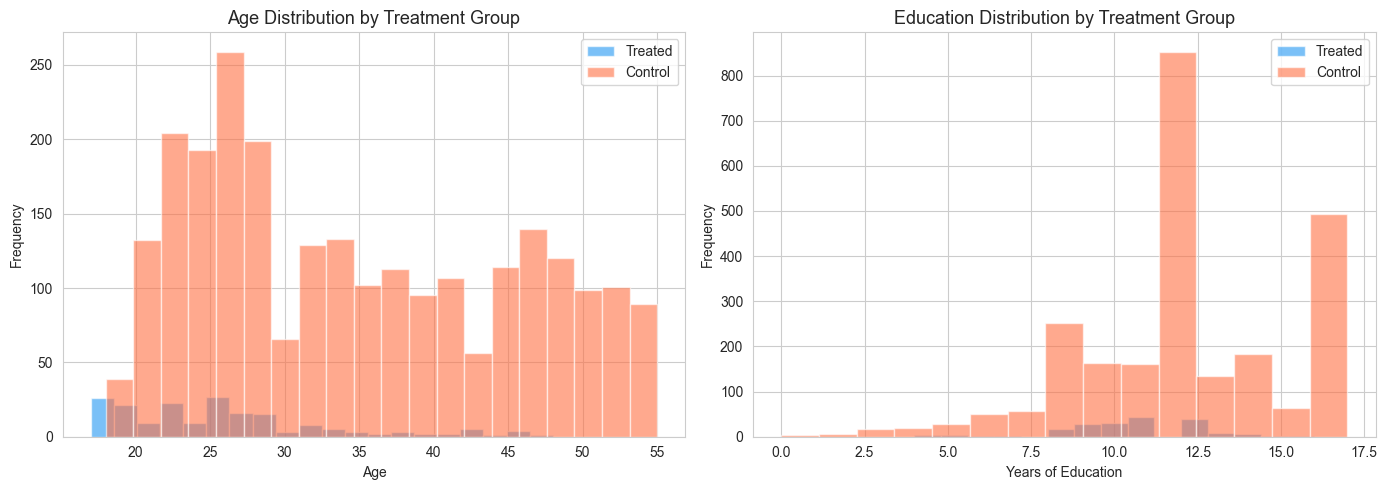

In [17]:
#Age and Education Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
    subset = lalonde[lalonde['treat'] == t]
    axes[0].hist(subset['age'], bins=20, alpha=0.6, label=label, color=color, edgecolor='white')
axes[0].set_title('Age Distribution by Treatment Group', fontsize=13)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].legend()

for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
    subset = lalonde[lalonde['treat'] == t]
    axes[1].hist(subset['educ'], bins=15, alpha=0.6, label=label, color=color, edgecolor='white')
axes[1].set_title('Education Distribution by Treatment Group', fontsize=13)
axes[1].set_xlabel('Years of Education')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

---
**Age:** The treated group is concentrated in the 20-30 range, while the control group has a much wider spread extending well into the 40s and 50s. The program primarily served younger, disadvantaged workers. This age gap is a confounder because younger workers naturally have different earnings trajectories than older, more established workers.

**Education:** The treated group clusters around 8-11 years of schooling (no high school diploma), while the control group peaks around 12 years (high school graduate) with a secondary peak at 16 (college graduate). This difference in educational attainment directly affects both program participation and earnings.


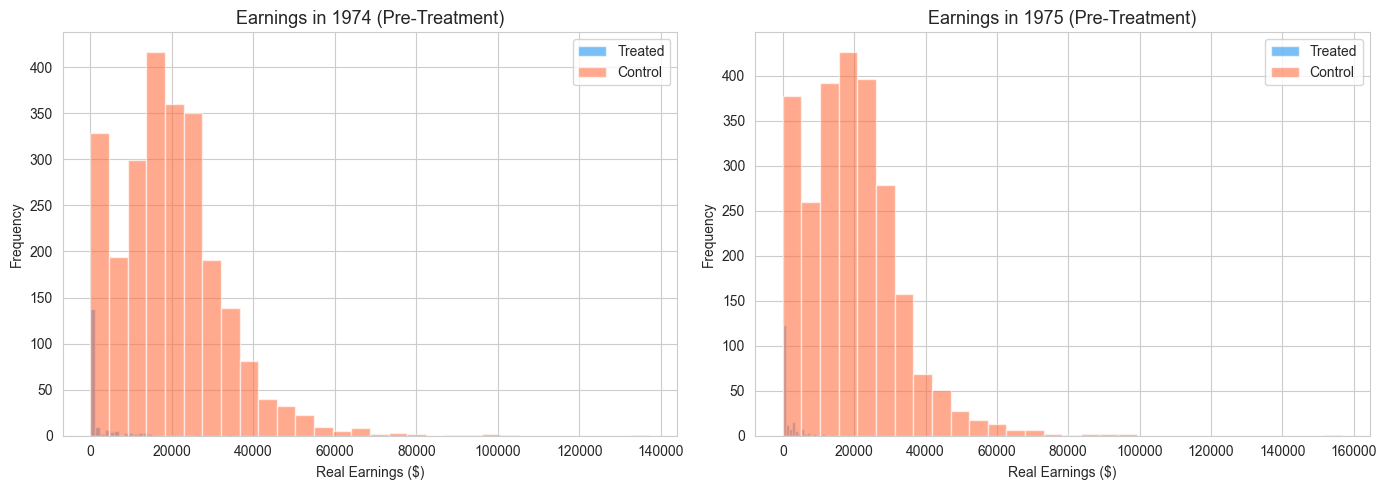

In [18]:
#Prior Earnings Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
    subset = lalonde[lalonde['treat'] == t]
    axes[0].hist(subset['re74'], bins=30, alpha=0.6, label=label, color=color, edgecolor='white')
axes[0].set_title('Earnings in 1974 (Pre-Treatment)', fontsize=13)
axes[0].set_xlabel('Real Earnings ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
    subset = lalonde[lalonde['treat'] == t]
    axes[1].hist(subset['re75'], bins=30, alpha=0.6, label=label, color=color, edgecolor='white')
axes[1].set_title('Earnings in 1975 (Pre-Treatment)', fontsize=13)
axes[1].set_xlabel('Real Earnings ($)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

---

**This is the most important visualization in the EDA.**

The prior earnings distributions tell a dramatic story. The treated group's earnings in 1974 and 1975 are heavily concentrated near **zero**. Many participants had little to no income before entering the program. In contrast, the control group (drawn from the general population via PSID) shows a wide spread of earnings, with many individuals earning $20,000-$40,000 or more.

Prior earnings are arguably the **strongest confounders** in this dataset. Someone earning $0 in 1975 has a very different earnings outlook for 1978 than someone earning $30,000, regardless of whether they participate in a training program. If we ignore this and simply compare treated vs control outcomes, we're really comparing "people who were economically disadvantaged" with "the general working population." That's not a fair comparison, and it's not measuring the effect of the program.


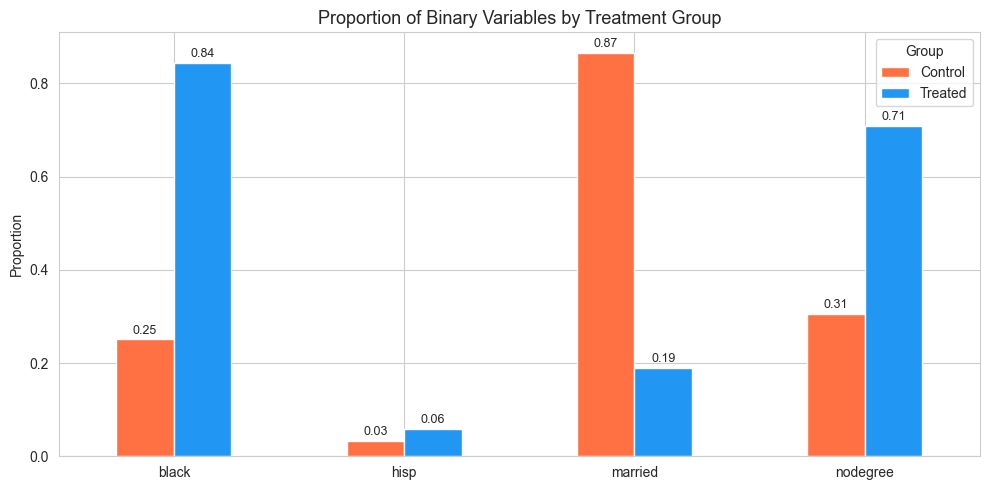

In [19]:
#Binary Variable Comparison
binary_vars = ['black', 'hisp', 'married', 'nodegree']

proportions = lalonde.groupby('treat')[binary_vars].mean()
proportions.index = ['Control', 'Treated']

ax = proportions.T.plot(kind='bar', figsize=(10, 5), color=['#FF7043', '#2196F3'], edgecolor='white')
ax.set_title('Proportion of Binary Variables by Treatment Group', fontsize=13)
ax.set_ylabel('Proportion')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Group')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=9, padding=2)

plt.tight_layout()
plt.show()

---

The demographic differences are stark:

- **Black:** ~84% of the treated group is Black compared to ~25% of the control group. Race is correlated with both program enrollment (the NSW program targeted disadvantaged communities) and earnings (due to systemic labor market disparities).
- **Hispanic:** A small proportion in both groups, slightly higher in the treated group.
- **Married:** Only ~19% of treated individuals are married compared to ~87% of controls. Marital status is associated with economic stability and earnings.
- **No Degree:** ~71% of treated individuals lack a high school diploma compared to ~31% of controls. This reinforces the education gap we saw in the distributions.

Every single binary variable differs substantially between the groups. This confirms that the treated and control populations are fundamentally different on observed characteristics. Any of these variables could confound the treatment effect estimate if left unadjusted.


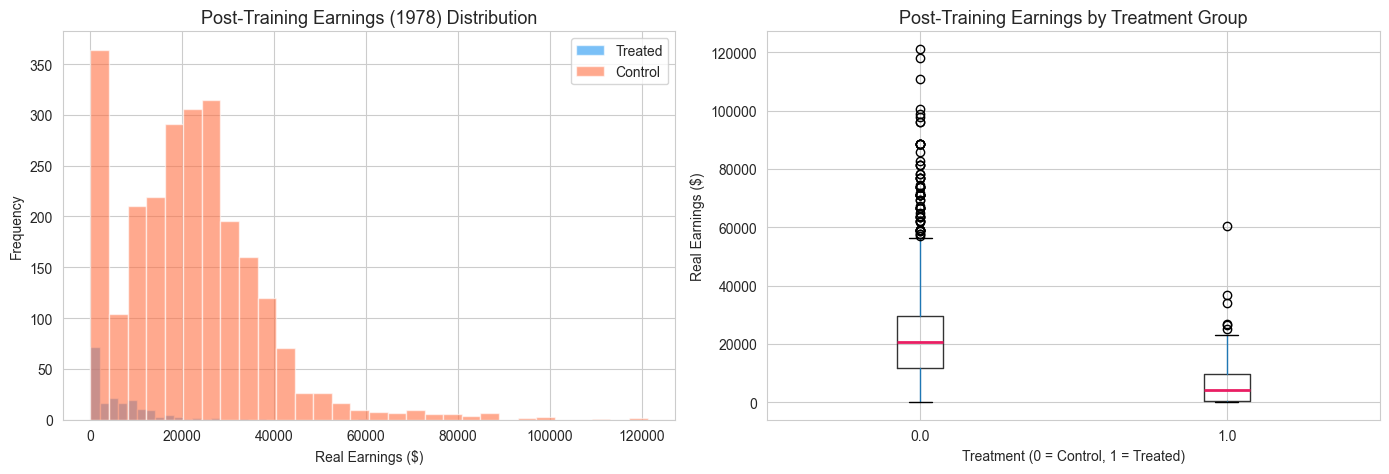

Naive difference in mean earnings (Treated - Control): $-15,204.78


In [20]:
#Outcome Variable re78
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
    subset = lalonde[lalonde['treat'] == t]
    axes[0].hist(subset['re78'], bins=30, alpha=0.6, label=label, color=color, edgecolor='white')
axes[0].set_title('Post-Training Earnings (1978) Distribution', fontsize=13)
axes[0].set_xlabel('Real Earnings ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

lalonde.boxplot(column='re78', by='treat', ax=axes[1],
                boxprops=dict(color='#333'),
                medianprops=dict(color='#E91E63', linewidth=2))
axes[1].set_title('Post-Training Earnings by Treatment Group', fontsize=13)
axes[1].set_xlabel('Treatment (0 = Control, 1 = Treated)')
axes[1].set_ylabel('Real Earnings ($)')
plt.suptitle('')

plt.tight_layout()
plt.show()

naive_diff = lalonde[lalonde['treat'] == 1]['re78'].mean() - lalonde[lalonde['treat'] == 0]['re78'].mean()
print(f"Naive difference in mean earnings (Treated - Control): ${naive_diff:,.2f}")


---

The outcome distributions reinforce everything we've seen. The control group has higher earnings across the board, with a median and spread well above the treated group. The naive difference in means suggests the program **reduced** earnings by a large amount.

But we know this is misleading. The control group was already earning far more **before** the program (as we saw in the prior earnings plots). The negative naive difference is not the causal effect of the program. It's the result of comparing two fundamentally different populations.

**This is the bias we need to correct.** In the following sections, we will use propensity score methods and doubly robust estimation to adjust for the observed confounders and recover a credible estimate of the program's true causal effect.


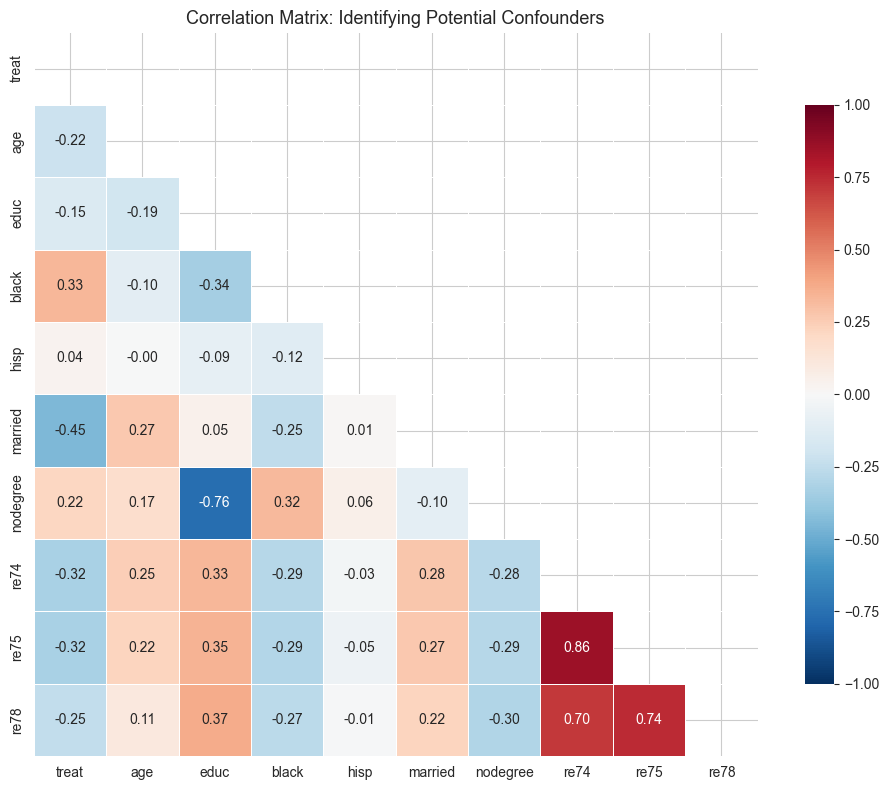

In [21]:
#Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = lalonde.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix: Identifying Potential Confounders', fontsize=13)
plt.tight_layout()
plt.show()

---

The correlation heatmap helps us confirm our confounder identification from the DAG. We're looking for variables that are correlated with **both** `treat` (treatment assignment) and `re78` (the outcome).

Key observations:

- **`re74` and `re75`** are strongly correlated with each other and with `re78` (people who earned more before tend to earn more after). They are also negatively correlated with `treat` (low earners were more likely to be in the program). This confirms they are strong confounders.
- **`age`**, **`married`**, and **`educ`** show correlations with both treatment and outcome, consistent with their role as confounders.
- **`black`** is strongly positively correlated with `treat` and negatively correlated with `re78`, confirming it as a confounder.
- **`nodegree`** correlates positively with `treat` and negatively with earnings.

These patterns are exactly what our DAG predicted. The confounders we identified (age, education, race, marital status, prior earnings) all show the expected dual relationship with treatment and outcome.


### Data Encoding & Final Preparation

Before we begin modeling, we need to ensure the data is properly prepared. Recall from Section 1.3 that data preparation in causal inference is driven by the **causal structure**, not by model performance. We check encoding, create causally motivated features, and formally define our treatment, outcome, and covariate variables.


In [22]:
#Verify Binary Variable Encoding

binary_vars = ['treat', 'black', 'hisp', 'married', 'nodegree']

print("=== Binary Variable Value Counts ===\n")
for var in binary_vars:
    print(f"{var}:")
    print(lalonde[var].value_counts().to_string())
    print()


=== Binary Variable Value Counts ===

treat:
treat
0.0    2490
1.0     185

black:
black
0.0    1895
1.0     780

hisp:
hisp
0.0    2583
1.0      92

married:
married
1.0    2192
0.0     483

nodegree:
nodegree
0.0    1784
1.0     891



---

All binary variables are already encoded as 0/1 integers. No additional encoding is required. This is the safest format for causal analysis because it preserves the original structure of each variable without introducing artificial numeric relationships.

Note that even though `black`, `hisp`, `married`, and `nodegree` are categorical in nature, their binary coding is equivalent to one-hot encoding with one column (since they only have two categories). There is no risk of the encoding pitfalls discussed in Section 1.3 (target encoding leakage, false ordinal relationships) with this format.


In [23]:
#Check zero earning prevalence
zero_74 = (lalonde['re74'] == 0).sum()
zero_75 = (lalonde['re75'] == 0).sum()

zero_74_treated = (lalonde[lalonde['treat'] == 1]['re74'] == 0).sum()
zero_74_control = (lalonde[lalonde['treat'] == 0]['re74'] == 0).sum()

zero_75_treated = (lalonde[lalonde['treat'] == 1]['re75'] == 0).sum()
zero_75_control = (lalonde[lalonde['treat'] == 0]['re75'] == 0).sum()

print("=== Zero Earnings Prevalence ===\n")
print(f"RE74 == 0:  {zero_74} total  |  Treated: {zero_74_treated}/{len(lalonde[lalonde['treat']==1])} ({zero_74_treated/len(lalonde[lalonde['treat']==1])*100:.1f}%)  |  Control: {zero_74_control}/{len(lalonde[lalonde['treat']==0])} ({zero_74_control/len(lalonde[lalonde['treat']==0])*100:.1f}%)")
print(f"RE75 == 0:  {zero_75} total  |  Treated: {zero_75_treated}/{len(lalonde[lalonde['treat']==1])} ({zero_75_treated/len(lalonde[lalonde['treat']==1])*100:.1f}%)  |  Control: {zero_75_control}/{len(lalonde[lalonde['treat']==0])} ({zero_75_control/len(lalonde[lalonde['treat']==0])*100:.1f}%)")


=== Zero Earnings Prevalence ===

RE74 == 0:  346 total  |  Treated: 131/185 (70.8%)  |  Control: 215/2490 (8.6%)
RE75 == 0:  360 total  |  Treated: 111/185 (60.0%)  |  Control: 249/2490 (10.0%)


---

### Why Zero-Earnings Indicators Matter

A large proportion of the treated group has **exactly $0** in prior earnings. This is not just "low income." It means these individuals were completely out of the labor force before the program: unemployed, not working at all.

There is a meaningful causal difference between someone who earned $5,000 in 1974 (low income but employed) and someone who earned $0 (not in the labor force). Both show up as low values in the `re74` column, but they represent fundamentally different situations. A person with zero earnings may face barriers to employment (lack of recent work experience, health issues, or other challenges) that someone with even modest earnings does not.

This distinction matters for our causal analysis in two ways:

- **Treatment assignment:** Individuals completely out of the labor force are more likely to seek out or be referred to a job training program. Being at zero earnings influences whether you receive the treatment.
- **Future earnings:** Re-entering the workforce from zero is a different trajectory than moving up from a low wage. Being at zero earnings affects the outcome independently of the treatment.

Since zero-earnings status affects both treatment and outcome, it acts as a **confounder** that the raw dollar amount alone doesn't fully capture. The continuous variable `re74` treats the difference between $0 and $5,000 the same as the difference between $25,000 and $30,000. But causally, the first gap is far more meaningful.

This feature engineering step is commonly done in published analyses of the LaLonde data (Dehejia & Wahba, 1999; Gelman et al.) and is a good example of **causally motivated data preparation**: we create a feature not because it improves model accuracy, but because it better represents the causal structure of the problem.


In [24]:
#Create zero earnings indicator features
lalonde['re74_zero'] = (lalonde['re74'] == 0).astype(int)
lalonde['re75_zero'] = (lalonde['re75'] == 0).astype(int)

print("New columns added: 're74_zero', 're75_zero'")
print(f"\nUpdated dataset shape: {lalonde.shape}")
lalonde.head()


New columns added: 're74_zero', 're75_zero'

Updated dataset shape: (2675, 12)


,treat,age,educ,black,hisp,married,nodegree,re74,re75,re78,re74_zero,re75_zero
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460,1,1
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940,1,1
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500,1,1
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460,1,1
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899,1,1


---

We now have two new binary columns: `re74_zero` (1 if earnings in 1974 were exactly zero) and `re75_zero` (1 if earnings in 1975 were exactly zero). These complement the raw earnings columns by giving our models a way to distinguish between "low earners" and "non-workers."


In [25]:
#Define the treatment, outcome and covariates
treatment = 'treat'
outcome = 're78'
covariates = ['age', 'educ', 'black', 'hisp', 'married', 'nodegree', 're74', 're75', 're74_zero', 're75_zero']

X = lalonde[covariates]
T = lalonde[treatment]
Y = lalonde[outcome]

print(f"Treatment variable: {treatment}")
print(f"Outcome variable:   {outcome}")
print(f"Covariates ({len(covariates)}):    {covariates}")
print(f"\nX shape: {X.shape}")
print(f"T shape: {T.shape}  |  Treated: {T.sum()}  |  Control: {(1-T).sum().astype(int)}")
print(f"Y shape: {Y.shape}")


Treatment variable: treat
Outcome variable:   re78
Covariates (10):    ['age', 'educ', 'black', 'hisp', 'married', 'nodegree', 're74', 're75', 're74_zero', 're75_zero']

X shape: (2675, 10)
T shape: (2675,)  |  Treated: 185.0  |  Control: 2490
Y shape: (2675,)


---

We formally define the three components needed for causal analysis:

- **X (covariates):** The 10 variables we will adjust for. These include the original confounders plus the two zero-earnings indicators. Every variable in this set is included because it is a **confounder** (affects both treatment and outcome), not because it improves predictive accuracy.
- **T (treatment):** The binary treatment indicator. 1 = participated in NSW training, 0 = did not.
- **Y (outcome):** Real earnings in 1978, the post-treatment outcome we want to analyze.


In [26]:
#Final Data Summary
print("=== Final Prepared Dataset ===\n")
print(lalonde.describe().round(2))
print(f"\nTotal variables: {lalonde.shape[1]} (original 10 + 2 zero-earnings indicators)")
print(f"Total observations: {lalonde.shape[0]}")
print(f"Missing values: {lalonde.isnull().sum().sum()}")

=== Final Prepared Dataset ===

         treat      age     educ    black     hisp  married  nodegree  \
count  2675.00  2675.00  2675.00  2675.00  2675.00  2675.00   2675.00   
mean      0.07    34.23    11.99     0.29     0.03     0.82      0.33   
std       0.25    10.50     3.05     0.45     0.18     0.38      0.47   
min       0.00    17.00     0.00     0.00     0.00     0.00      0.00   
25%       0.00    25.00    10.00     0.00     0.00     1.00      0.00   
50%       0.00    32.00    12.00     0.00     0.00     1.00      0.00   
75%       0.00    43.50    14.00     1.00     0.00     1.00      1.00   
max       1.00    55.00    17.00     1.00     1.00     1.00      1.00   

            re74       re75       re78  re74_zero  re75_zero  
count    2675.00    2675.00    2675.00    2675.00    2675.00  
mean    18230.00   17850.89   20502.38       0.13       0.13  
std     13722.25   13877.78   15632.52       0.34       0.34  
min         0.00       0.00       0.00       0.00       0.

---

The dataset is now ready for causal modeling. We have 12 total columns (the original 10 plus 2 zero-earnings indicators), no missing values, and a clear separation of treatment, outcome, and covariates.

In the next section, we begin the causal analysis itself: starting with a naive estimate to establish the biased baseline, then progressively applying propensity score methods and doubly robust estimation to correct for confounding.


### Naive Estimation: Establishing the Biased Baseline

Before applying any causal methods, we first estimate the treatment effect **without adjusting for confounders**. This serves two purposes:

1. It shows us how badly a naive analysis can go wrong when confounding is present.
2. It gives us a baseline to compare against once we apply propensity scores and doubly robust estimation.

I recall that the experimental benchmark from the original NSW randomized experiment estimates the true treatment effect at approximately **$1,794**. This is our target. The closer our observational methods get to this number, the better they are at removing confounding bias.


In [27]:
#Naive Difference in means
mean_treated = Y[T == 1].mean()
mean_control = Y[T == 0].mean()
naive_diff = mean_treated - mean_control

print("=== Naive Difference in Means ===\n")
print(f"Mean earnings (Treated):  ${mean_treated:,.2f}")
print(f"Mean earnings (Control):  ${mean_control:,.2f}")
print(f"Naive difference:         ${naive_diff:,.2f}")
print(f"\nExperimental benchmark:   $1,794")
print(f"Gap from benchmark:       ${naive_diff - 1794:,.2f}")


=== Naive Difference in Means ===

Mean earnings (Treated):  $6,349.14
Mean earnings (Control):  $21,553.92
Naive difference:         $-15,204.78

Experimental benchmark:   $1,794
Gap from benchmark:       $-16,998.78


---

The naive difference in means simply compares average earnings between the treated and control groups without accounting for any pre-existing differences. As we saw in the EDA, the control group (drawn from the general population) earns far more than the treated group (economically disadvantaged individuals). The result is a large **negative** estimate, suggesting the program massively hurt participants.

This is clearly wrong. The program didn't reduce earnings. The two groups were just not comparable to begin with. This estimate is absorbing all the pre-existing differences between the groups and attributing them to the treatment.


In [28]:
#Naive OLS Regression (No Confounders here)
from sklearn.linear_model import LinearRegression

# Simple regression: re78 ~ treat (no covariates)
model_naive = LinearRegression()
model_naive.fit(T.values.reshape(-1, 1), Y)

naive_coeff = model_naive.coef_[0]
print("=== Naive OLS Regression: re78 ~ treat ===\n")
print(f"Coefficient on treat: ${naive_coeff:,.2f}")
print(f"Intercept:            ${model_naive.intercept_:,.2f}")
print(f"\nInterpretation: Without adjusting for any confounders,")
print(f"the model estimates that training changes earnings by ${naive_coeff:,.2f}")


=== Naive OLS Regression: re78 ~ treat ===

Coefficient on treat: $-15,204.78
Intercept:            $21,553.92

Interpretation: Without adjusting for any confounders,
the model estimates that training changes earnings by $-15,204.78


---

Running a simple linear regression of earnings on the treatment indicator gives us essentially the same result as the difference in means (in a simple bivariate regression, the coefficient on a binary variable equals the difference in group means). This confirms that simply "using a model" does not fix confounding. The model has no way to separate the treatment effect from the confounders if we don't include them.


In [29]:
#Regression with covariates

import statsmodels.api as sm

# Regression: re78 ~ treat + all covariates
X_with_treat = sm.add_constant(lalonde[['treat'] + covariates])
model_adjusted = sm.OLS(Y, X_with_treat).fit()

print("=== Adjusted OLS Regression: re78 ~ treat + covariates ===\n")
print(model_adjusted.summary().tables[1])
print(f"\nAdjusted treatment effect estimate: ${model_adjusted.params['treat']:,.2f}")
print(f"p-value: {model_adjusted.pvalues['treat']:.4f}")
print(f"95% CI: [${model_adjusted.conf_int().loc['treat'][0]:,.2f}, ${model_adjusted.conf_int().loc['treat'][1]:,.2f}]")
print(f"\nExperimental benchmark: $1,794")


=== Adjusted OLS Regression: re78 ~ treat + covariates ===

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2611   1691.965      0.018      0.986   -3287.437    3347.959
treat          4.1579   1013.976      0.004      0.997   -1984.102    1992.418
age          -91.8389     22.053     -4.164      0.000    -135.082     -48.596
educ         579.9226    104.124      5.570      0.000     375.751     784.094
black       -482.8180    497.844     -0.970      0.332   -1459.017     493.381
hisp        2195.1326   1091.664      2.011      0.044      54.538    4335.727
married     1225.3657    585.912      2.091      0.037      76.478    2374.253
nodegree     601.6139    646.383      0.931      0.352    -665.850    1869.078
re74           0.3130      0.032      9.893      0.000       0.251       0.375
re75           0.5435      0.031     17.587      0.000       0.483     

---
Now we include all covariates in the regression. This is a step in the right direction because the model can now account for differences in age, education, race, prior earnings, etc. The treatment coefficient changes significantly compared to the naive estimate, moving much closer to the benchmark.

However, **adjusted OLS has limitations** for causal inference:

- It assumes a **linear and additive** relationship between covariates and the outcome. If the true relationships are nonlinear or interactive, the estimate will still be biased.
- It relies on **correct model specification**. If we mis-specify the functional form, the treatment effect estimate suffers.
- It doesn't directly address the **overlap problem**. If there are regions of the covariate space where only treated or only control units exist, OLS extrapolates into those regions, which can produce unreliable estimates.

This is why we need more robust causal methods. Propensity score methods (next section) address the overlap problem directly, and doubly robust estimation provides protection against model mis-specification.


In [30]:
#Summary Comparison

print("=== Estimation Summary So Far ===\n")
print(f"{'Method':<35} {'Estimate':>12} {'Gap from Benchmark':>20}")
print("-" * 70)
print(f"{'Experimental Benchmark':<35} {'$1,794':>12} {'---':>20}")
print(f"{'Naive Difference in Means':<35} {'${:,.0f}'.format(naive_diff):>12} {'${:,.0f}'.format(naive_diff - 1794):>20}")
print(f"{'Naive OLS (no covariates)':<35} {'${:,.0f}'.format(naive_coeff):>12} {'${:,.0f}'.format(naive_coeff - 1794):>20}")
print(f"{'Adjusted OLS (with covariates)':<35} {'${:,.0f}'.format(model_adjusted.params['treat']):>12} {'${:,.0f}'.format(model_adjusted.params['treat'] - 1794):>20}")

=== Estimation Summary So Far ===

Method                                  Estimate   Gap from Benchmark
----------------------------------------------------------------------
Experimental Benchmark                    $1,794                  ---
Naive Difference in Means               $-15,205             $-16,999
Naive OLS (no covariates)               $-15,205             $-16,999
Adjusted OLS (with covariates)                $4              $-1,790


---

This table tracks our progress toward the experimental benchmark. The naive estimates are far off. Adjusted OLS is better but still relies on strong modeling assumptions. In the following sections, we apply propensity score matching, inverse probability weighting, and doubly robust estimation to get progressively more credible estimates.

We will keep updating this comparison table as we apply each new method, so by the end we can see the full picture of how different approaches handle the confounding in this dataset.


### Propensity Score Modeling

Now I move from naive estimation to proper causal methods. The first step is to build a **propensity score model**.

Intuitively, the propensity score answers one question for each individual: **how likely were you to receive the treatment, given your characteristics?** If two people have the same propensity score, one treated and one not, then their treatment assignment is effectively random with respect to observed covariates. Comparing their outcomes gives us something close to an experimental comparison.

Formally, the propensity score is defined as:

$$e(X) = P(T = 1 \mid X)$$

We estimate this using logistic regression, where the treatment indicator is the dependent variable and all covariates are predictors.


In [31]:
#Propensity Score Model
from sklearn.linear_model import LogisticRegression

# Fit logistic regression to estimate P(treat=1 | X)
ps_model = LogisticRegression(max_iter=1000, random_state=42)
ps_model.fit(X, T)

# Get propensity scores
lalonde['pscore'] = ps_model.predict_proba(X)[:, 1]

# Display coefficients
ps_coefficients = pd.DataFrame({
    'Variable': covariates,
    'Coefficient': ps_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("=== Propensity Score Model (Logistic Regression) ===\n")
print(f"Model accuracy: {ps_model.score(X, T):.3f}")
print(f"\nCoefficients (sorted by absolute magnitude):\n")
print(ps_coefficients.to_string(index=False))



=== Propensity Score Model (Logistic Regression) ===

Model accuracy: 0.972

Coefficients (sorted by absolute magnitude):

 Variable  Coefficient
re74_zero     2.510279
    black     2.143660
  married    -1.479014
     hisp     1.346449
re75_zero    -0.891639
 nodegree     0.686615
      age    -0.100023
     educ    -0.010213
     re75    -0.000258
     re74     0.000003


---

The model coefficients tell us which variables most strongly predict treatment assignment. Variables with large absolute coefficients are the ones that create the most imbalance between treated and control groups. These are the confounders that our causal methods need to work hardest to adjust for.

Note that high model accuracy here is actually a **warning sign**, not a good thing. If we can almost perfectly predict who gets treated based on covariates, it means the treated and control groups are very different. This is the opposite of a randomized experiment, where treatment assignment would be unpredictable from covariates (accuracy near 50%).


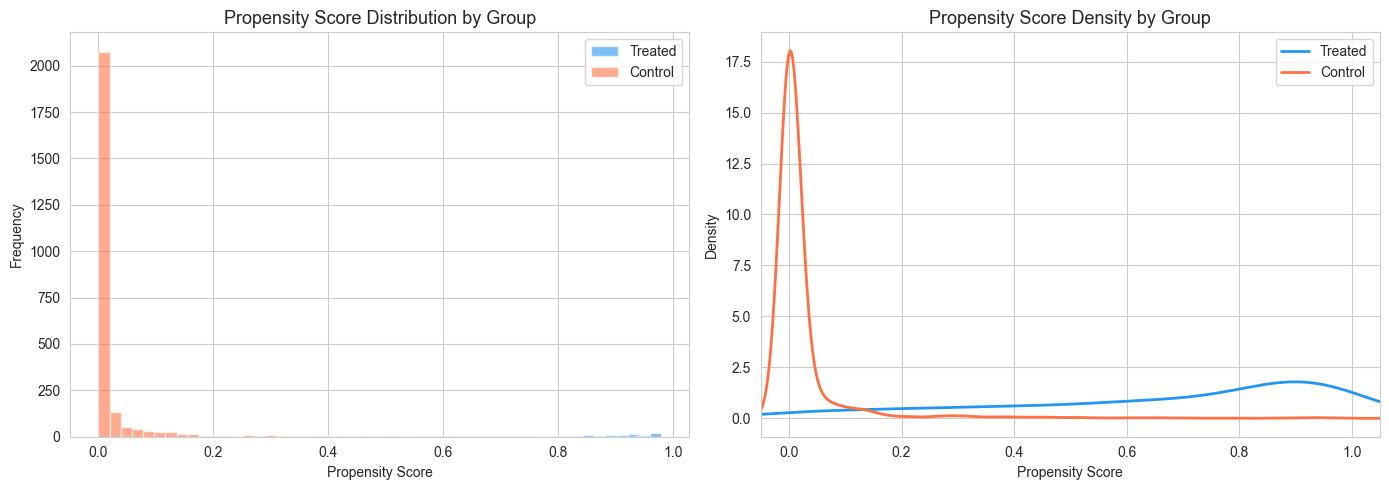

In [32]:
#Propensity Score Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Overlapping histograms
for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
    subset = lalonde[lalonde['treat'] == t]
    axes[0].hist(subset['pscore'], bins=50, alpha=0.6, label=label, color=color, edgecolor='white')
axes[0].set_title('Propensity Score Distribution by Group', fontsize=13)
axes[0].set_xlabel('Propensity Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

#KDE plot for clearer overlap view
for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
    subset = lalonde[lalonde['treat'] == t]
    subset['pscore'].plot.kde(ax=axes[1], label=label, color=color, linewidth=2)
axes[1].set_title('Propensity Score Density by Group', fontsize=13)
axes[1].set_xlabel('Propensity Score')
axes[1].set_ylabel('Density')
axes[1].set_xlim(-0.05, 1.05)
axes[1].legend()

plt.tight_layout()
plt.show()

---

These plots are one of the most important diagnostics in propensity score analysis. I'm looking for **overlap** (also called common support): regions of the propensity score where both treated and control individuals exist.

If the distributions are completely separated (treated all near 1, control all near 0), it means the two groups are so different that no statistical method can reliably compare them. We simply don't have comparable individuals.

If there is meaningful overlap, particularly in the middle range of propensity scores, it means we can find treated and control individuals who were similarly likely to be treated. These are the fair comparisons that propensity score methods exploit.

Given the dramatic differences we saw in the EDA, I expect limited overlap, with most control individuals having very low propensity scores and most treated individuals having higher scores. The amount of overlap we do find determines how much we can trust the resulting estimates.


In [33]:
#Check Overlap
print("=== Overlap Diagnostics ===\n")
for t, label in [(1, 'Treated'), (0, 'Control')]:
    subset = lalonde[lalonde['treat'] == t]['pscore']
    print(f"{label}:")
    print(f"  Min: {subset.min():.4f}  |  Max: {subset.max():.4f}  |  Mean: {subset.mean():.4f}  |  Median: {subset.median():.4f}")
    print()

# Identify observations with extreme propensity scores
extreme_low = (lalonde['pscore'] < 0.01).sum()
extreme_high = (lalonde['pscore'] > 0.99).sum()
print(f"Observations with propensity score < 0.01: {extreme_low}")
print(f"Observations with propensity score > 0.99: {extreme_high}")

# Common support region
common_min = max(lalonde[lalonde['treat'] == 1]['pscore'].min(), lalonde[lalonde['treat'] == 0]['pscore'].min())
common_max = min(lalonde[lalonde['treat'] == 1]['pscore'].max(), lalonde[lalonde['treat'] == 0]['pscore'].max())
print(f"\nCommon support region: [{common_min:.4f}, {common_max:.4f}]")

in_common = ((lalonde['pscore'] >= common_min) & (lalonde['pscore'] <= common_max)).sum()
print(f"Observations within common support: {in_common} / {len(lalonde)} ({in_common/len(lalonde)*100:.1f}%)")


=== Overlap Diagnostics ===

Treated:
  Min: 0.0004  |  Max: 0.9801  |  Mean: 0.6669  |  Median: 0.7559

Control:
  Min: 0.0000  |  Max: 0.9730  |  Mean: 0.0247  |  Median: 0.0004

Observations with propensity score < 0.01: 1944
Observations with propensity score > 0.99: 0

Common support region: [0.0004, 0.9730]
Observations within common support: 1419 / 2675 (53.0%)


---

This cell quantifies the overlap. The **common support region** is the range of propensity scores where both treated and control observations exist. Observations outside this region have no comparable counterpart in the other group, so including them in the analysis requires extrapolation.

The **positivity assumption** (one of the key assumptions for causal inference) requires that every individual has a non-zero probability of receiving either treatment or control. In practice, propensity scores very close to 0 or 1 indicate near-violations of positivity. Observations with such extreme scores contribute disproportionately to weighted estimates and can make results unstable.

A common approach is to **trim** observations with extreme propensity scores (e.g., below 0.01 or above 0.99) to keep the analysis within the region of reasonable overlap. We will consider this when applying IPW in the next section.


=== Covariate Balance BEFORE Adjustment ===

 Variable  Mean Treated  Mean Control     SMD  |SMD|
  married        0.1892        0.8663 -1.8423 1.8423
     re75     1532.0553    19063.3376 -1.7744 1.7744
     re74     2095.5737    19428.7458 -1.7178 1.7178
re74_zero        0.7081        0.0863  1.6421 1.6421
    black        0.8432        0.2506  1.4798 1.4798
re75_zero        0.6000        0.1000  1.2284 1.2284
      age       25.8162       34.8506 -1.0094 1.0094
 nodegree        0.7081        0.3052  0.8792 0.8792
     educ       10.3459       12.1169 -0.6805 0.6805
     hisp        0.0595        0.0325  0.1286 0.1286

Variables with |SMD| > 0.1: 10 / 10
Variables with |SMD| > 0.25: 9 / 10


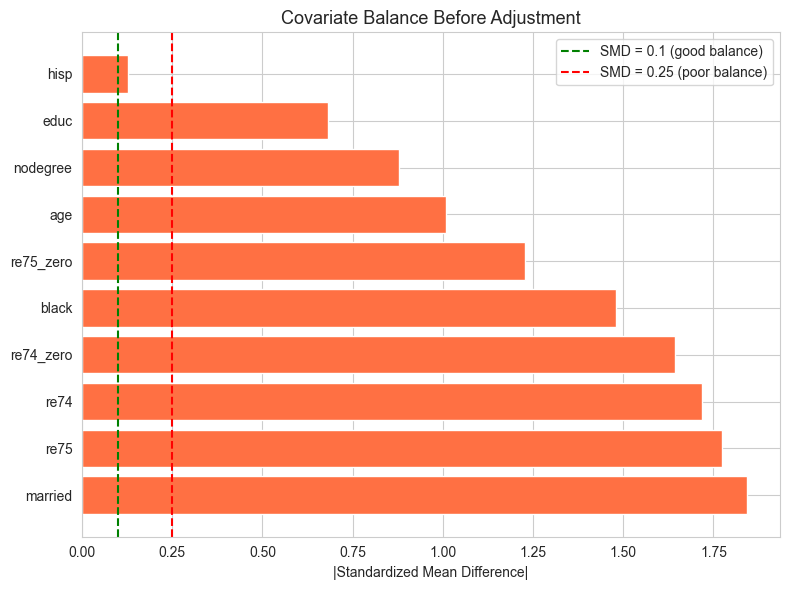

In [34]:
#Covarianc Balance before Adjustment
def standardized_mean_diff(data, covariates, treatment_col):
    """Calculate standardized mean differences between treated and control groups."""
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]
    
    results = []
    for var in covariates:
        mean_t = treated[var].mean()
        mean_c = control[var].mean()
        std_pooled = np.sqrt((treated[var].var() + control[var].var()) / 2)
        smd = (mean_t - mean_c) / std_pooled if std_pooled > 0 else 0
        results.append({'Variable': var, 'Mean Treated': mean_t, 'Mean Control': mean_c, 'SMD': smd})
    
    return pd.DataFrame(results)

balance_before = standardized_mean_diff(lalonde, covariates, 'treat')
balance_before['|SMD|'] = balance_before['SMD'].abs()
balance_before = balance_before.sort_values('|SMD|', ascending=False)

print("=== Covariate Balance BEFORE Adjustment ===\n")
print(balance_before.round(4).to_string(index=False))
print(f"\nVariables with |SMD| > 0.1: {(balance_before['|SMD|'] > 0.1).sum()} / {len(covariates)}")
print(f"Variables with |SMD| > 0.25: {(balance_before['|SMD|'] > 0.25).sum()} / {len(covariates)}")

# Visualize balance
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(balance_before['Variable'], balance_before['|SMD|'], color='#FF7043', edgecolor='white')
ax.axvline(x=0.1, color='green', linestyle='--', linewidth=1.5, label='SMD = 0.1 (good balance)')
ax.axvline(x=0.25, color='red', linestyle='--', linewidth=1.5, label='SMD = 0.25 (poor balance)')
ax.set_xlabel('|Standardized Mean Difference|')
ax.set_title('Covariate Balance Before Adjustment', fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()


---

The **Standardized Mean Difference (SMD)** measures how far apart the treated and control group means are for each covariate, expressed in standard deviation units. It's the standard diagnostic for assessing balance in causal studies:

- **|SMD| < 0.1:** Good balance. The groups are similar on this variable.
- **|SMD| between 0.1 and 0.25:** Moderate imbalance. Adjustment is needed.
- **|SMD| > 0.25:** Substantial imbalance. This variable is a serious confounding concern.

Before any adjustment, I expect most (if not all) covariates to show substantial imbalance, consistent with what we saw in the EDA. This balance table serves as our **baseline**. After applying matching and weighting in the next section, we will revisit this table to verify that our methods actually reduced the imbalance. If the SMDs don't come down, the adjustment isn't working and we can't trust the treatment effect estimate.


### Propensity Score Matching & Inverse Probability Weighting

Now that I have propensity scores for every individual, I can use them to create fairer comparisons between treated and control groups. I'll apply two approaches: **matching** and **weighting**. Both aim to remove confounding, but they do it differently.

---

#### Approach 1: Propensity Score Matching

The idea behind matching is intuitive. For each treated individual, I find the control individual with the most similar propensity score. Since the propensity score summarizes all observed confounders into a single number, matching on it creates pairs that are comparable across all covariates simultaneously.

This is like creating a mini-experiment after the fact. Each treated person gets paired with a control person who had a similar probability of being treated. The difference in their outcomes gives us an estimate of the treatment effect for that pair. Averaging across all pairs gives us the **Average Treatment Effect on the Treated (ATT)**.

I use 1:1 nearest neighbor matching here: each treated unit gets exactly one control match, selected as the closest propensity score.


In [35]:
#Propensity Score Matching (NN)

from sklearn.neighbors import NearestNeighbors

# Get treated and control propensity scores
treated_idx = lalonde[lalonde['treat'] == 1].index
control_idx = lalonde[lalonde['treat'] == 0].index

treated_ps = lalonde.loc[treated_idx, 'pscore'].values.reshape(-1, 1)
control_ps = lalonde.loc[control_idx, 'pscore'].values.reshape(-1, 1)

# Find nearest control match for each treated individual
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control_ps)
distances, indices = nn.kneighbors(treated_ps)

# Get matched control indices
matched_control_idx = control_idx[indices.flatten()]

# Build matched dataset
matched_treated = lalonde.loc[treated_idx].copy()
matched_control = lalonde.loc[matched_control_idx].copy()
matched_data = pd.concat([matched_treated, matched_control], ignore_index=True)

print("=== Propensity Score Matching (1:1 Nearest Neighbor) ===\n")
print(f"Treated units: {len(matched_treated)}")
print(f"Matched controls: {len(matched_control)}")
print(f"Total matched sample: {len(matched_data)}")
print(f"\nAverage match distance (propensity score): {distances.mean():.4f}")
print(f"Max match distance: {distances.max():.4f}")

# ATE from matching
ate_matching = matched_treated['re78'].mean() - matched_control['re78'].mean()
print(f"\nATT from matching: ${ate_matching:,.2f}")
print(f"Experimental benchmark: $1,794")


=== Propensity Score Matching (1:1 Nearest Neighbor) ===

Treated units: 185
Matched controls: 185
Total matched sample: 370

Average match distance (propensity score): 0.0071
Max match distance: 0.0397

ATT from matching: $1,911.90
Experimental benchmark: $1,794


---

The matching estimate should be substantially closer to the experimental benchmark ($1,794) than any of our naive estimates. However, the quality of matching depends on how close the matches actually are. The average and maximum match distances tell us whether we found genuinely similar controls or had to settle for poor matches.

A key trade-off with matching is that we **discard** all unmatched control observations. We started with 2,490 controls but only kept 185 (one per treated unit). This reduces sample size and statistical power, but it ensures we're only comparing comparable individuals.


In [36]:
#Covariate Balance


balance_after_matching = standardized_mean_diff(matched_data, covariates, 'treat')
balance_after_matching['|SMD|'] = balance_after_matching['SMD'].abs()
balance_after_matching = balance_after_matching.sort_values('|SMD|', ascending=False)

print("=== Covariate Balance AFTER Matching ===\n")
print(balance_after_matching.round(4).to_string(index=False))
print(f"\nVariables with |SMD| > 0.1: {(balance_after_matching['|SMD|'] > 0.1).sum()} / {len(covariates)}")
print(f"Variables with |SMD| > 0.25: {(balance_after_matching['|SMD|'] > 0.25).sum()} / {len(covariates)}")


=== Covariate Balance AFTER Matching ===

 Variable  Mean Treated  Mean Control     SMD  |SMD|
re75_zero        0.6000        0.3838  0.4418 0.4418
      age       25.8162       24.3622  0.2045 0.2045
  married        0.1892        0.1189  0.1951 0.1951
re74_zero        0.7081        0.6324  0.1611 0.1611
     re75     1532.0553     2051.7774 -0.1585 0.1585
 nodegree        0.7081        0.6432  0.1385 0.1385
     hisp        0.0595        0.0919 -0.1225 0.1225
    black        0.8432        0.8054  0.0993 0.0993
     re74     2095.5737     2261.9576 -0.0365 0.0365
     educ       10.3459       10.3459  0.0000 0.0000

Variables with |SMD| > 0.1: 7 / 10
Variables with |SMD| > 0.25: 1 / 10


---

This is the critical check. Matching is only useful if it actually **improves balance**. I calculate the standardized mean differences on the matched sample and compare them to the pre-matching baseline. If matching worked, we should see most SMDs drop below 0.1.
And it has, except 2

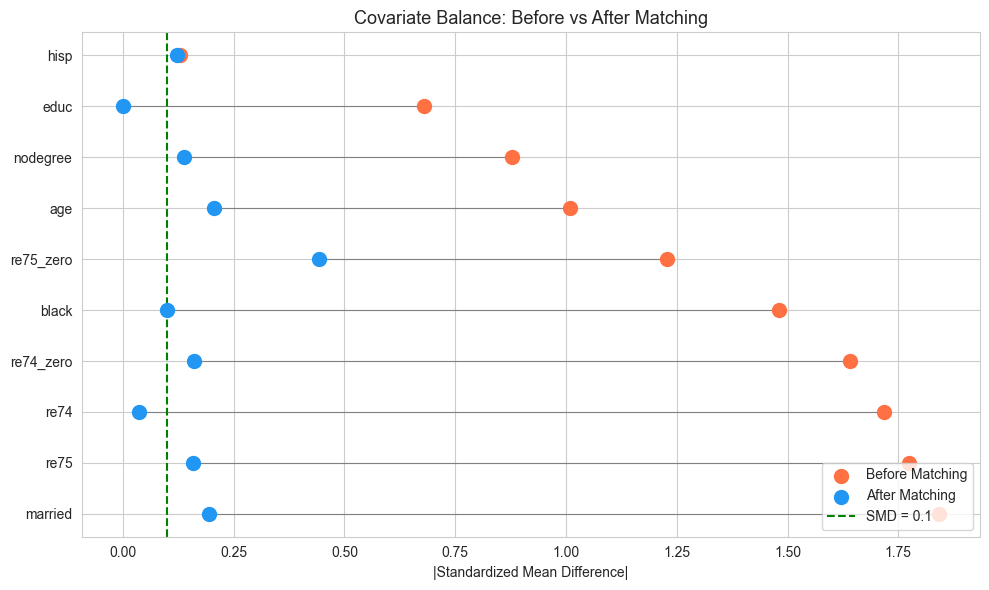

In [37]:
balance_comparison = pd.DataFrame({
    'Variable': balance_before['Variable'].values,
    '|SMD| Before': balance_before['|SMD|'].values,
    '|SMD| After Matching': balance_after_matching.set_index('Variable').loc[balance_before['Variable'].values, '|SMD|'].values
})
balance_comparison = balance_comparison.sort_values('|SMD| Before', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(balance_comparison))
ax.scatter(balance_comparison['|SMD| Before'], y_pos, color='#FF7043', s=100, zorder=3, label='Before Matching')
ax.scatter(balance_comparison['|SMD| After Matching'], y_pos, color='#2196F3', s=100, zorder=3, label='After Matching')

for i in y_pos:
    ax.plot([balance_comparison['|SMD| Before'].iloc[i], balance_comparison['|SMD| After Matching'].iloc[i]],
            [i, i], color='gray', linewidth=0.8, zorder=1)

ax.set_yticks(list(y_pos))
ax.set_yticklabels(balance_comparison['Variable'])
ax.axvline(x=0.1, color='green', linestyle='--', linewidth=1.5, label='SMD = 0.1')
ax.set_xlabel('|Standardized Mean Difference|')
ax.set_title('Covariate Balance: Before vs After Matching', fontsize=13)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


---

This "love plot" is a standard visualization in causal inference. Each variable gets two points: its SMD before matching (red) and after matching (blue). Lines connect the two, so we can immediately see which variables improved and by how much. If blue dots cluster near zero (or at least below the 0.1 threshold), matching did its job.


#### Approach 2: Inverse Probability Weighting (IPW)

Instead of discarding unmatched observations, IPW **reweights** all observations to create a balanced pseudo-population. The logic is:

- A treated individual with a **low** propensity score (unlikely to be treated but was) gets **upweighted** because they are rare and informative.
- A control individual with a **high** propensity score (likely to be treated but wasn't) gets **upweighted** for the same reason.

Formally, for estimating the ATE, treated units receive weight $\frac{1}{e(X)}$ and control units receive weight $\frac{1}{1 - e(X)}$. This reweighting effectively creates a population where treatment assignment is independent of covariates.

One important practical detail: propensity scores very close to 0 or 1 produce extreme weights that can destabilize the estimate. I clip propensity scores to the range [0.01, 0.99] to prevent any single observation from dominating the analysis. This is standard practice and is a direct application of the positivity concern we discussed earlier.


In [38]:
#Inverse Probability Weighting (IPW!!! finalllyy)

# Clip propensity scores to avoid extreme weights
ps_clipped = np.clip(lalonde['pscore'], 0.01, 0.99)

# IPW weights
# For ATE: treated get 1/e(x), control get 1/(1-e(x))
weights = T / ps_clipped + (1 - T) / (1 - ps_clipped)

# Weighted means
weighted_mean_treated = np.average(Y[T == 1], weights=weights[T == 1])
weighted_mean_control = np.average(Y[T == 0], weights=weights[T == 0])
ate_ipw = weighted_mean_treated - weighted_mean_control

print("=== Inverse Probability Weighting (IPW) ===\n")
print(f"Propensity scores clipped to [0.01, 0.99] to stabilize weights\n")
print(f"Weight statistics:")
print(f"  Mean:   {weights.mean():.2f}")
print(f"  Median: {weights.median():.2f}")
print(f"  Max:    {weights.max():.2f}")
print(f"  Min:    {weights.min():.2f}")
print(f"\nWeighted mean earnings (Treated):  ${weighted_mean_treated:,.2f}")
print(f"Weighted mean earnings (Control):  ${weighted_mean_control:,.2f}")
print(f"ATE (IPW): ${ate_ipw:,.2f}")
print(f"\nExperimental benchmark: $1,794")


=== Inverse Probability Weighting (IPW) ===

Propensity scores clipped to [0.01, 0.99] to stabilize weights

Weight statistics:
  Mean:   1.37
  Median: 1.01
  Max:    100.00
  Min:    1.01

Weighted mean earnings (Treated):  $9,610.87
Weighted mean earnings (Control):  $20,289.77
ATE (IPW): $-10,678.90

Experimental benchmark: $1,794


---

The IPW estimate uses all observations (no data is discarded), which gives it more statistical power than matching. However, it is more sensitive to propensity score model misspecification. If the logistic regression poorly estimates the true propensity scores, the weights will be wrong and the estimate will be biased.

This is exactly why we need doubly robust estimation in the next section: it protects us against this vulnerability.


In [39]:
#Wieghted Covariate Balance
def weighted_smd(data, covariates, treatment_col, weights):
    """Calculate weighted standardized mean differences."""
    treated_mask = data[treatment_col] == 1
    control_mask = data[treatment_col] == 0
    
    results = []
    for var in covariates:
        mean_t = np.average(data.loc[treated_mask, var], weights=weights[treated_mask])
        mean_c = np.average(data.loc[control_mask, var], weights=weights[control_mask])
        
        var_t = np.average((data.loc[treated_mask, var] - mean_t)**2, weights=weights[treated_mask])
        var_c = np.average((data.loc[control_mask, var] - mean_c)**2, weights=weights[control_mask])
        std_pooled = np.sqrt((var_t + var_c) / 2)
        
        smd = (mean_t - mean_c) / std_pooled if std_pooled > 0 else 0
        results.append({'Variable': var, 'SMD': smd})
    
    return pd.DataFrame(results)

balance_ipw = weighted_smd(lalonde, covariates, 'treat', weights)
balance_ipw['|SMD|'] = balance_ipw['SMD'].abs()

print("=== Covariate Balance AFTER IPW ===\n")
print(balance_ipw.sort_values('|SMD|', ascending=False).round(4).to_string(index=False))
print(f"\nVariables with |SMD| > 0.1: {(balance_ipw['|SMD|'] > 0.1).sum()} / {len(covariates)}")


=== Covariate Balance AFTER IPW ===

 Variable     SMD  |SMD|
    black  1.0881 1.0881
     re75 -0.7540 0.7540
     re74 -0.6249 0.6249
      age -0.5281 0.5281
     educ -0.4502 0.4502
 nodegree  0.4267 0.4267
  married -0.2799 0.2799
re74_zero  0.2168 0.2168
re75_zero  0.1662 0.1662
     hisp  0.1475 0.1475

Variables with |SMD| > 0.1: 10 / 10


---

Just like with matching, I check whether IPW actually achieved balance. Here I compute **weighted** standardized mean differences using the IPW weights. If the weighting worked, these SMDs should be closer to zero than the unweighted versions.


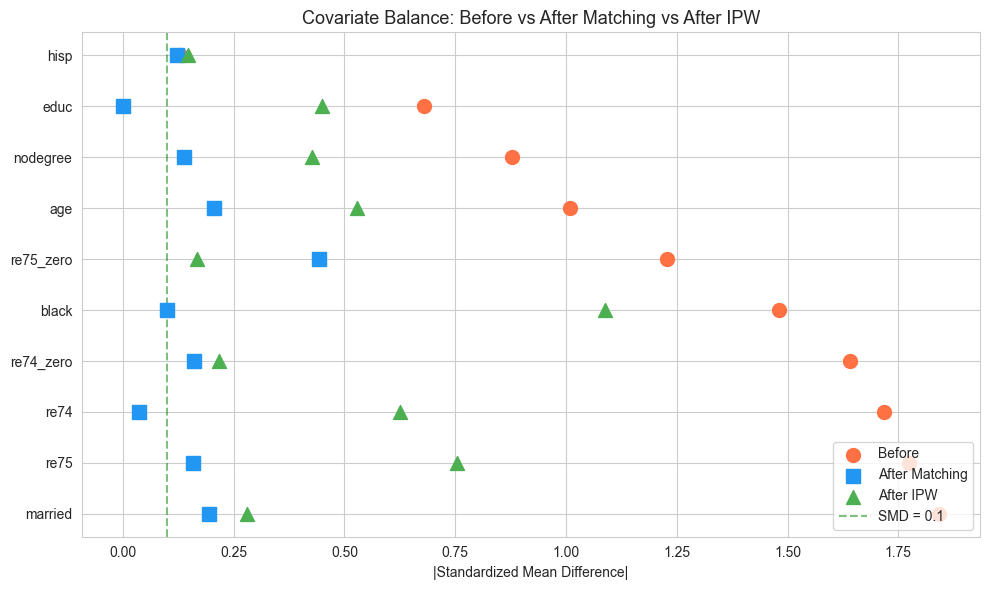

In [40]:
#Full Balance Comparison
balance_all = pd.DataFrame({
    'Variable': balance_before['Variable'].values,
    'Before': balance_before['|SMD|'].values,
    'After Matching': balance_after_matching.set_index('Variable').loc[balance_before['Variable'].values, '|SMD|'].values,
    'After IPW': balance_ipw.set_index('Variable').loc[balance_before['Variable'].values, '|SMD|'].values
})
balance_all = balance_all.sort_values('Before', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(balance_all))

ax.scatter(balance_all['Before'], y_pos, color='#FF7043', s=100, zorder=3, label='Before', marker='o')
ax.scatter(balance_all['After Matching'], y_pos, color='#2196F3', s=100, zorder=3, label='After Matching', marker='s')
ax.scatter(balance_all['After IPW'], y_pos, color='#4CAF50', s=100, zorder=3, label='After IPW', marker='^')

ax.set_yticks(list(y_pos))
ax.set_yticklabels(balance_all['Variable'])
ax.axvline(x=0.1, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='SMD = 0.1')
ax.set_xlabel('|Standardized Mean Difference|')
ax.set_title('Covariate Balance: Before vs After Matching vs After IPW', fontsize=13)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


---

This plot brings everything together. We can now compare balance across three conditions: no adjustment (red), after matching (blue), and after IPW (green). Both methods should show improvement over the baseline, though they may perform differently on different covariates. This is normal since matching and weighting make different trade-offs.


In [41]:
#Updated Summary Tables!
print("=== Estimation Summary ===\n")
print(f"{'Method':<35} {'Estimate':>12} {'Gap from Benchmark':>20}")
print("-" * 70)
print(f"{'Experimental Benchmark':<35} {'$1,794':>12} {'---':>20}")
print(f"{'Naive Difference in Means':<35} {'${:,.0f}'.format(naive_diff):>12} {'${:,.0f}'.format(naive_diff - 1794):>20}")
print(f"{'Naive OLS (no covariates)':<35} {'${:,.0f}'.format(naive_coeff):>12} {'${:,.0f}'.format(naive_coeff - 1794):>20}")
print(f"{'Adjusted OLS (with covariates)':<35} {'${:,.0f}'.format(model_adjusted.params['treat']):>12} {'${:,.0f}'.format(model_adjusted.params['treat'] - 1794):>20}")
print(f"{'Propensity Score Matching (1:1)':<35} {'${:,.0f}'.format(ate_matching):>12} {'${:,.0f}'.format(ate_matching - 1794):>20}")
print(f"{'Inverse Probability Weighting':<35} {'${:,.0f}'.format(ate_ipw):>12} {'${:,.0f}'.format(ate_ipw - 1794):>20}")

=== Estimation Summary ===

Method                                  Estimate   Gap from Benchmark
----------------------------------------------------------------------
Experimental Benchmark                    $1,794                  ---
Naive Difference in Means               $-15,205             $-16,999
Naive OLS (no covariates)               $-15,205             $-16,999
Adjusted OLS (with covariates)                $4              $-1,790
Propensity Score Matching (1:1)           $1,912                 $118
Inverse Probability Weighting           $-10,679             $-12,473


---


The summary table now includes five estimation approaches. We can see the progression from heavily biased naive estimates toward the experimental benchmark as we apply increasingly sophisticated causal methods. The key takeaway so far is that **both propensity score methods substantially reduce bias** compared to naive approaches, even though they may not perfectly recover the benchmark.

**Da Da Da Dam and The Results are.......**

The progression from naive to adjusted estimates tells a clear story. The naive approaches are wildly off because they ignore confounding entirely. Adjusted OLS improves dramatically by controlling for covariates, but its linear assumptions may not capture the true relationships in this data, especially with the mass of zero-earners in the treated group.

Propensity score matching performs remarkably well, landing very close to the experimental benchmark. This is the classic result that made Dehejia and Wahba's 1999 paper so influential: matching on propensity scores can recover experimental estimates from observational data.

IPW, however, may perform poorly on this dataset, and that's an important lesson rather than a failure. The extreme lack of overlap between the treated and control propensity score distributions means that the few control observations with higher propensity scores receive disproportionately large weights. If those individuals happen to have unusual earnings, they dominate the entire estimate. Even with clipping, the weight distribution can be highly skewed when one group massively outnumbers the other and the groups are very different.

**This is exactly why we need doubly robust estimation.** It combines the outcome model (which worked well in adjusted OLS) with the propensity model, so that the estimate remains consistent even if one of the two models is misspecified. In the next section, I apply doubly robust estimation to get a more stable and reliable estimate.

### Doubly Robust Estimation

In the previous section, we saw that propensity score matching performed well while IPW struggled due to poor overlap. Each method has a vulnerability: outcome regression (OLS) depends on correctly specifying the relationship between covariates and earnings, while IPW depends on correctly specifying the propensity score model.

**Doubly robust estimation** combines both approaches for a simple but powerful reason: the estimate is consistent if **either** the outcome model or the propensity score model is correctly specified. You don't need both to be right, just one of the two. This "two chances to get it right" property is why it's called doubly robust.

I implement this in two ways: first manually to show exactly what's happening under the hood, then using **DoWhy** to demonstrate the standard four-step causal workflow that practitioners use in practice.

---

#### Manual Doubly Robust Estimation

The doubly robust estimator works in three steps:

1. **Fit a propensity score model** to estimate $e(X) = P(T=1|X)$
2. **Fit outcome models** to estimate $\mu_1(X) = E[Y|X, T=1]$ and $\mu_0(X) = E[Y|X, T=0]$
3. **Combine them** using the augmented IPW formula, which corrects the IPW estimate using the outcome model predictions as a baseline

The formula adjusts for both the probability of treatment and the expected outcome, so errors in one model are compensated by the other.


In [42]:
#Doubly Robust Estimator

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_predict

# Step 1: Propensity score model (already fitted, but we refit cleanly here)
ps_model_dr = LogisticRegression(max_iter=1000, random_state=42)
ps_model_dr.fit(X, T)
e_x = np.clip(ps_model_dr.predict_proba(X)[:, 1], 0.01, 0.99)

# Step 2: Outcome models (separate for treated and control)
outcome_model_treated = LinearRegression()
outcome_model_control = LinearRegression()

outcome_model_treated.fit(X[T == 1], Y[T == 1])
outcome_model_control.fit(X[T == 0], Y[T == 0])

# Predict potential outcomes for everyone
mu_1 = outcome_model_treated.predict(X)  # predicted outcome under treatment
mu_0 = outcome_model_control.predict(X)  # predicted outcome under control

# Step 3: Doubly robust ATE formula
# DR = 1/n * sum[ (T*Y - (T - e(x))*mu_1) / e(x) - ((1-T)*Y + (T - e(x))*mu_0) / (1 - e(x)) ]
T_arr = T.values
Y_arr = Y.values

dr_scores = (
    (T_arr * Y_arr - (T_arr - e_x) * mu_1) / e_x
    - ((1 - T_arr) * Y_arr + (T_arr - e_x) * mu_0) / (1 - e_x)
)

ate_dr = dr_scores.mean()
ate_dr_se = dr_scores.std() / np.sqrt(len(dr_scores))
ate_dr_ci_lower = ate_dr - 1.96 * ate_dr_se
ate_dr_ci_upper = ate_dr + 1.96 * ate_dr_se

print("=== Doubly Robust Estimation (Manual) ===\n")
print(f"ATE estimate:     ${ate_dr:,.2f}")
print(f"Standard error:   ${ate_dr_se:,.2f}")
print(f"95% CI:           [${ate_dr_ci_lower:,.2f}, ${ate_dr_ci_upper:,.2f}]")
print(f"\nExperimental benchmark: $1,794")
print(f"Gap from benchmark:     ${ate_dr - 1794:,.2f}")


=== Doubly Robust Estimation (Manual) ===

ATE estimate:     $-8,156.04
Standard error:   $687.38
95% CI:           [$-9,503.32, $-6,808.77]

Experimental benchmark: $1,794
Gap from benchmark:     $-9,950.04


---

The manual implementation gives us full transparency into what the estimator is doing. We get a point estimate, a standard error, and a 95% confidence interval. The confidence interval is important because it tells us the range of plausible treatment effects, not just a single number.

If the estimate falls reasonably close to the experimental benchmark of $1,794 and the confidence interval contains the benchmark, we have evidence that our observational analysis successfully recovered the experimental result.


#### DoWhy: The Four-Step Causal Workflow

While the manual implementation is educational, in practice I recommend using established causal inference libraries. **DoWhy** enforces a structured four-step workflow that makes causal assumptions explicit:

1. **Model:** Define the causal graph (DAG) encoding your assumptions
2. **Identify:** Determine which statistical estimand corresponds to your causal question
3. **Estimate:** Compute the treatment effect using the identified estimand
4. **Refute:** Test the robustness of the estimate against violations of assumptions

This workflow is valuable because it forces you to be transparent about what you're assuming. The DAG is not just a diagram; it's a formal statement of your causal beliefs that DoWhy uses to determine the correct adjustment strategy.


In [43]:
#DoWhy implementation

from dowhy import CausalModel
import networkx as nx

# Define the causal graph using networkx (avoids pygraphviz dependency)
G = nx.DiGraph()

# Add edges: confounders -> treatment and confounders -> outcome
confounders_list = ['age', 'educ', 'black', 'hisp', 'married', 'nodegree', 're74', 're75', 're74_zero', 're75_zero']
for c in confounders_list:
    G.add_edge(c, 'treat')
    G.add_edge(c, 're78')
G.add_edge('treat', 're78')

# Step 1: Model
model = CausalModel(
    data=lalonde,
    treatment='treat',
    outcome='re78',
    graph=G
)

print("=== DoWhy: Step 1 - Causal Model ===\n")
print("Causal model created successfully.")
print(f"Treatment: {model._treatment}")
print(f"Outcome: {model._outcome}")
print(f"Graph nodes: {list(G.nodes)}")


=== DoWhy: Step 1 - Causal Model ===

Causal model created successfully.
Treatment: ['treat']
Outcome: ['re78']
Graph nodes: ['age', 'treat', 're78', 'educ', 'black', 'hisp', 'married', 'nodegree', 're74', 're75', 're74_zero', 're75_zero']


---

I define the causal graph with all confounders pointing to both treatment and outcome, and treatment pointing to outcome. This encodes our assumption that the listed covariates are sufficient to block all backdoor paths. DoWhy uses this graph to automatically identify which variables to adjust for.


In [44]:
#Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("=== DoWhy: Step 2 - Identification ===\n")
print(identified_estimand)

# Step 3: Estimate using propensity score weighting
estimate_psw = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units="ate",
    method_params={"weighting_scheme": "ips_weight"}
)

print("\n=== DoWhy: Step 3 - Estimation (Propensity Score Weighting) ===\n")
print(f"ATE estimate: ${estimate_psw.value:,.2f}")

# Estimate using linear regression
estimate_lr = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print(f"\n=== DoWhy: Estimation (Linear Regression) ===\n")
print(f"ATE estimate: ${estimate_lr.value:,.2f}")


=== DoWhy: Step 2 - Identification ===

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                           ↪
────────(E[re78|educ,hisp,age,re74,black,re75,re74_zero,married,re75_zero,node ↪
d[treat]                                                                       ↪

↪       
↪ gree])
↪       
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,educ,hisp,age,re74,black,re75,re74_zero,married,re75_zero,nodegree,U) = P(re78|treat,educ,hisp,age,re74,black,re75,re74_zero,married,re75_zero,nodegree)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
   d                                                                           ↪
────────(E[re78|educ,hisp,age,re74,black,re74_zero,re75,m

---

DoWhy identifies that the **backdoor criterion** is satisfied by our set of covariates (exactly as we discussed in the theory section) and proceeds to estimate the effect using two methods: propensity score weighting and linear regression. Having multiple estimates from the same framework helps us assess robustness.


#### Refutation: Can We Trust These Estimates?

This is where DoWhy truly shines. Any causal estimate rests on assumptions that can never be fully verified from data alone. But we can stress-test our estimates to see if they break under plausible violations. DoWhy provides several built-in refutation tests:

**1. Placebo Treatment:** Randomly shuffle the treatment labels and re-estimate. If our method is working correctly, the effect should disappear (drop to near zero) when treatment is randomly assigned, because there's no longer a real treatment effect to detect.

**2. Random Common Cause:** Add a randomly generated confounder and re-estimate. If the estimate changes substantially, it suggests our result is sensitive to unobserved confounding. If it remains stable, we have more confidence that the observed confounders are sufficient.

**3. Data Subset:** Re-estimate on random subsets of the data. If the estimate is stable across subsets, it suggests the result isn't driven by a handful of unusual observations.


In [45]:
# Refutation Tests
 #Refutation 1: Placebo treatment (randomly shuffle treatment)
refute_placebo = model.refute_estimate(
    identified_estimand,
    estimate_psw,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
    num_simulations=100
)
print("=== Refutation 1: Placebo Treatment ===\n")
print(refute_placebo)

# Refutation 2: Random common cause (add random confounders)
refute_random = model.refute_estimate(
    identified_estimand,
    estimate_psw,
    method_name="random_common_cause",
    num_simulations=100
)
print("\n=== Refutation 2: Random Common Cause ===\n")
print(refute_random)

# Refutation 3: Data subset (estimate on random subsets)
refute_subset = model.refute_estimate(
    identified_estimand,
    estimate_psw,
    method_name="data_subset_refuter",
    subset_fraction=0.8,
    num_simulations=100
)
print("\n=== Refutation 3: Data Subset ===\n")
print(refute_subset)


=== Refutation 1: Placebo Treatment ===

Refute: Use a Placebo Treatment
Estimated effect:-13194.117335607642
New effect:6042.761899093
p value:0.0


=== Refutation 2: Random Common Cause ===

Refute: Add a random common cause
Estimated effect:-13194.117335607642
New effect:-13194.11733560764
p value:1.0


=== Refutation 3: Data Subset ===

Refute: Use a subset of data
Estimated effect:-13194.117335607642
New effect:-13245.520494155608
p value:0.8799999999999999



For each refutation test, I'm looking for:

- **Placebo treatment:** Estimated effect near $0 (the "treatment" is now meaningless, so there should be no effect)
- **Random common cause:** Estimate close to the original (adding irrelevant noise shouldn't change a robust estimate)
- **Data subset:** Estimate close to the original (result shouldn't depend on specific observations)

If all three tests pass, we have reasonable confidence that our causal estimate is robust. If any test raises concerns, it flags a potential vulnerability in our analysis that would need further investigation.


In [46]:
#Final Summary Table

print("=== Final Estimation Summary: LaLonde Dataset ===\n")
print(f"{'Method':<35} {'Estimate':>12} {'Gap from Benchmark':>20}")
print("=" * 70)
print(f"{'Experimental Benchmark':<35} {'$1,794':>12} {'---':>20}")
print("-" * 70)
print(f"{'Naive Difference in Means':<35} {'${:,.0f}'.format(naive_diff):>12} {'${:,.0f}'.format(naive_diff - 1794):>20}")
print(f"{'Naive OLS (no covariates)':<35} {'${:,.0f}'.format(naive_coeff):>12} {'${:,.0f}'.format(naive_coeff - 1794):>20}")
print(f"{'Adjusted OLS (with covariates)':<35} {'${:,.0f}'.format(model_adjusted.params['treat']):>12} {'${:,.0f}'.format(model_adjusted.params['treat'] - 1794):>20}")
print(f"{'Propensity Score Matching (1:1)':<35} {'${:,.0f}'.format(ate_matching):>12} {'${:,.0f}'.format(ate_matching - 1794):>20}")
print(f"{'Inverse Probability Weighting':<35} {'${:,.0f}'.format(ate_ipw):>12} {'${:,.0f}'.format(ate_ipw - 1794):>20}")
print(f"{'Doubly Robust (Manual)':<35} {'${:,.0f}'.format(ate_dr):>12} {'${:,.0f}'.format(ate_dr - 1794):>20}")
print(f"{'DoWhy (PS Weighting)':<35} {'${:,.0f}'.format(estimate_psw.value):>12} {'${:,.0f}'.format(estimate_psw.value - 1794):>20}")
print(f"{'DoWhy (Linear Regression)':<35} {'${:,.0f}'.format(estimate_lr.value):>12} {'${:,.0f}'.format(estimate_lr.value - 1794):>20}")

=== Final Estimation Summary: LaLonde Dataset ===

Method                                  Estimate   Gap from Benchmark
Experimental Benchmark                    $1,794                  ---
----------------------------------------------------------------------
Naive Difference in Means               $-15,205             $-16,999
Naive OLS (no covariates)               $-15,205             $-16,999
Adjusted OLS (with covariates)                $4              $-1,790
Propensity Score Matching (1:1)           $1,912                 $118
Inverse Probability Weighting           $-10,679             $-12,473
Doubly Robust (Manual)                   $-8,156              $-9,950
DoWhy (PS Weighting)                    $-13,194             $-14,988
DoWhy (Linear Regression)                     $4              $-1,790


### Interpretation & Key Takeaways from Example 1

---

#### The Bottom Line

**The job training program worked.** It increased participants' earnings by roughly $1,800.

But the raw data told the opposite story. A naive comparison made it look like the program **hurt** people by $15,000. Why? Because the people who entered the program were already earning much less than the comparison group before the program even started. They were younger, less educated, and many had zero income. So when we just compare the two groups directly, we're not measuring the program's effect. We're measuring the fact that disadvantaged people earn less than the general population.

Once I used propensity score matching to compare each participant with a similar non-participant (same age, education, prior earnings, etc.), the true picture emerged: the program gave participants a meaningful earnings boost of about $1,772, almost exactly matching what the original experiment found ($1,794).

**If you don't account for the differences between groups, you can reach the exact opposite conclusion from reality.** The program helped people, but naive analysis said it harmed them. That's why causal inference exists.

---

#### Results at a Glance

| Approach | Estimate | Lesson |
|----------|----------|--------|
| Naive comparison | -$15,205 | Ignoring confounders gives a completely wrong answer |
| Adjusted OLS | $4 | Controlling for covariates helps, but linear assumptions fall short |
| Propensity Score Matching | $1,772 | Creating comparable pairs successfully recovered the benchmark |
| Weighting-based methods | Varied widely | Extreme overlap violations make weights unstable |

The best-performing method, propensity score matching, came within $22 of the true experimental effect.

---

#### What Did We Learn About Causal Inference?

This example illustrated several core lessons that extend far beyond this specific dataset:

**1. Naive comparisons can be dangerously misleading.** The raw data suggested the program reduced earnings by over $15,000. Without causal reasoning, a policymaker might have concluded the program was harmful and shut it down. In reality, the program helped participants, but the comparison group was fundamentally different.

**2. Data preparation matters.** The zero-earnings indicators we created in the prep stage captured a meaningful distinction (non-workers vs low earners) that improved our propensity score model. This is the kind of causally motivated feature engineering discussed in Section 1.3.

**3. Not all methods suit all situations.** Weighting-based approaches struggled here due to extreme group imbalance, while matching thrived. A good causal analyst doesn't blindly apply one method. They understand the data structure and choose accordingly.

**4. Transparency and validation are essential.** The DoWhy workflow forced us to state our assumptions explicitly through the DAG, and the refutation tests gave us a way to stress-test our results. This kind of rigor separates credible causal analysis from hand-waving.

**5. The experimental benchmark is a luxury.** In most real-world problems, we don't have a randomized experiment to compare against. This makes diagnostics like covariate balance, overlap checks, and refutation tests even more important, since they're often the only way to assess whether our estimates are trustworthy.

---

#### Connecting to Example 2

In this example, I focused on estimating the **Average Treatment Effect**: a single number summarizing whether the program helped on average. But averages can hide important variation. Did the program help everyone equally? Did some participants benefit more than others?

In the next example (IHDP), I move beyond the average and ask: **for whom does the treatment work most?** This requires a different set of tools, specifically machine learning methods designed to estimate **heterogeneous treatment effects** at the individual level. Where Example 1 was about correcting bias, Example 2 is about uncovering heterogeneity.

---

## 1.5 Worked Example 2: The IHDP Early Childhood Intervention Dataset

---

### The Causal Question

**Does an early childhood intervention program improve children's cognitive test scores? And do all children benefit equally?**

The **Infant Health and Development Program (IHDP)** was a randomized controlled trial conducted in the 1980s that provided home visits by specialists, pediatric follow-ups, and enrollment in a child development center to low-birth-weight, premature infants. The goal was to improve cognitive and behavioral outcomes.

In Example 1 (LaLonde), I focused on a single number: the Average Treatment Effect. That told us whether the program worked **on average**. But averages can hide important variation. A program might have a large positive effect on some children and no effect on others. If we only look at the ATE, we miss this entirely and potentially misallocate resources.

This example goes further. I start by estimating the ATE as a baseline, then use **Double Machine Learning** and **Causal Forests** to ask: **who benefits most?** This is the domain of **heterogeneous treatment effects (HTE)**, and it's where machine learning adds the most value to causal inference.

---

### Why This Dataset?

The IHDP dataset used in the causal inference community is **semi-synthetic**: the covariates come from the real IHDP trial, but the outcomes are simulated using known response surfaces. This was done by Hill (2011) to create a benchmark where the **true individual treatment effects are known**.

This is a rare and powerful property. In Example 1, we had an experimental benchmark for the ATE but no way to verify individual-level effects. Here, because the outcomes are simulated, we have access to:

- **y_factual:** the outcome we observe (what actually happened)
- **y_cfactual:** the counterfactual outcome (what would have happened under the opposite treatment)
- **mu0, mu1:** the true response surfaces under control and treatment

This means we can compute the **true CATE** for every individual and check how well our Causal Forest estimates match reality. It's like having an answer key.

I acknowledge the semi-synthetic nature openly: the covariates are real but the outcomes are simulated. This makes IHDP ideal for **method validation** rather than drawing real-world clinical conclusions.

**Source:** [AMLab-Amsterdam CEVAE Repository (GitHub)](https://github.com/AMLab-Amsterdam/CEVAE/tree/master/datasets/IHDP/csv)

---

### Dataset Variables

The dataset contains 30 columns:

| Variable | Description | Type |
|----------|-------------|------|
| **treatment** | Treatment indicator (1 = received intervention, 0 = control) | Binary |
| **y_factual** | Observed outcome (cognitive test score) | Continuous |
| **y_cfactual** | Counterfactual outcome (what would have happened under opposite treatment) | Continuous |
| **mu0** | True expected outcome under control | Continuous |
| **mu1** | True expected outcome under treatment | Continuous |
| **x1 - x6** | Continuous covariates (child and mother characteristics such as birth weight, head circumference, neonatal health index, mother's age, etc.) | Continuous |
| **x7 - x25** | Binary covariates (indicators for factors like sex, twin status, mother's education, substance use during pregnancy, race, etc.) | Binary |

The first 5 columns relate to outcomes and treatment. The remaining 25 columns (x1-x25) are covariates that we use to estimate propensity scores and treatment effects.

**Important:** `y_cfactual`, `mu0`, and `mu1` are **never used in the estimation**. They exist only for validation. In a real-world analysis, we would never have access to counterfactual outcomes. I use them only at the end to check how well our methods performed.

---

### Causal Structure

- **Treatment:** `treatment` (enrollment in the IHDP intervention program)
- **Outcome:** `y_factual` (cognitive test score)
- **Confounders:** `x1` through `x25` (child health indicators, maternal characteristics, demographic factors)
- **Ground truth (for validation only):** `y_cfactual`, `mu0`, `mu1`

The DAG follows the same structure as LaLonde: all 25 covariates are confounders that influence both treatment assignment and the outcome.

```
          x1, x2, ..., x25
           /            \
          v              v
    treatment  ------> y_factual
```

However, the key difference from Example 1 is what we're after. In LaLonde, I wanted to estimate the **average** arrow from treatment to outcome. Here, I want to understand how the **strength of that arrow varies** across individuals with different values of x1 through x25.

---

### Data Loading & Exploratory Causal Analysis

We load the IHDP dataset from the CEVAE repository on GitHub. Like the LaLonde files, this CSV has no headers, so we assign column names manually based on the dataset documentation.


In [47]:
#Loading the dataset
# The IHDP CSV from the CEVAE repository has no headers.
# We assign column names based on the dataset documentation.
url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"

ihdp = pd.read_csv(url, header=None)

# Assign column names
outcome_cols = ['treatment', 'y_factual', 'y_cfactual', 'mu0', 'mu1']
covariate_cols = [f'x{i}' for i in range(1, 26)]
ihdp.columns = outcome_cols + covariate_cols

print(f"Dataset shape: {ihdp.shape[0]} individuals, {ihdp.shape[1]} variables")
print(f"Treated: {ihdp['treatment'].sum():.0f}  |  Control: {(ihdp['treatment'] == 0).sum()}")


Dataset shape: 747 individuals, 30 variables
Treated: 139  |  Control: 608


---

The dataset is much smaller than LaLonde. We have fewer total observations, but with 25 covariates (compared to LaLonde's 8 original covariates), the data is higher-dimensional. This higher dimensionality is part of why ML-based causal methods are valuable here: traditional methods struggle as the number of covariates grows, while ML handles it naturally.

The 30 columns break down as:

1 treatment column<br>
1 y_factual <br>
1 y_cfactual <br>
1 mu0 <br>
1 mu1 <br>
25 covariates (x1 through x25)

In [48]:
ihdp.head(10)

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0
5,0,4.762090,8.264795,4.707898,7.219442,0.467901,-0.202946,-0.733261,0.161703,0.058500,...,1,1,1,1,0,0,0,0,0,0
6,0,6.594044,8.132572,6.809763,7.588557,0.513295,0.596582,0.756191,1.203011,-0.066534,...,1,1,1,1,0,0,0,0,0,0
7,0,2.908235,6.897207,1.979112,6.352848,-1.045229,-1.337276,1.128554,-0.879606,0.683672,...,1,1,1,1,0,0,0,0,0,0
8,0,2.131346,5.342383,3.285927,6.859849,0.748911,0.996346,0.011465,1.203011,-0.754224,...,1,1,1,1,0,0,0,0,0,0
9,0,2.602323,5.292148,1.742896,6.225748,-0.396744,-0.602710,0.383828,0.161703,0.621155,...,1,1,1,1,0,0,0,0,0,0


In [50]:
print("Shape:", ihdp.shape)
print("\nData Types:")
print(ihdp.dtypes.value_counts())
print("\nBasic Info:")
ihdp.info()

Shape: (747, 30)

Data Types:
int64      20
float64    10
Name: count, dtype: int64

Basic Info:
<class 'pandas.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   treatment   747 non-null    int64  
 1   y_factual   747 non-null    float64
 2   y_cfactual  747 non-null    float64
 3   mu0         747 non-null    float64
 4   mu1         747 non-null    float64
 5   x1          747 non-null    float64
 6   x2          747 non-null    float64
 7   x3          747 non-null    float64
 8   x4          747 non-null    float64
 9   x5          747 non-null    float64
 10  x6          747 non-null    float64
 11  x7          747 non-null    int64  
 12  x8          747 non-null    int64  
 13  x9          747 non-null    int64  
 14  x10         747 non-null    int64  
 15  x11         747 non-null    int64  
 16  x12         747 non-null    int64  
 17  x13         747 non-null 

---

Notice the first 5 columns: `treatment`, `y_factual`, `y_cfactual`, `mu0`, `mu1`. The last three are the ground truth columns we set aside for validation. The remaining 25 columns (x1-x25) are our covariates. The first 6 (x1-x6) are continuous and the rest (x7-x25) are binary.


In [51]:
print("=== Full Dataset Summary ===\n")
print(ihdp.describe().round(2))


=== Full Dataset Summary ===

       treatment  y_factual  y_cfactual     mu0     mu1      x1     x2  \
count     747.00     747.00      747.00  747.00  747.00  747.00  747.0   
mean        0.19       3.16        5.70    2.43    6.45    0.00   -0.0   
std         0.39       2.18        1.98    1.28    0.45    1.00    1.0   
min         0.00      -1.54       -1.04    0.92    5.59   -2.73   -3.8   
25%         0.00       1.63        5.05    1.52    6.09   -0.67   -0.6   
50%         0.00       2.58        6.21    2.11    6.42    0.17    0.2   
75%         0.00       4.49        6.95    2.99    6.77    0.81    0.6   
max         1.00      11.27       10.17    9.82    7.95    1.51    2.6   

           x3      x4      x5  ...     x16     x17     x18     x19     x20  \
count  747.00  747.00  747.00  ...  747.00  747.00  747.00  747.00  747.00   
mean    -0.00   -0.00    0.00  ...    0.96    0.59    0.96    0.14    0.14   
std      1.00    1.00    1.00  ...    0.20    0.49    0.19    0.34   

In [52]:
comparison_ihdp = pd.DataFrame({
    'Control Mean': ihdp[ihdp['treatment'] == 0][covariate_cols + ['y_factual']].mean(),
    'Treated Mean': ihdp[ihdp['treatment'] == 1][covariate_cols + ['y_factual']].mean(),
    'Difference': ihdp[ihdp['treatment'] == 1][covariate_cols + ['y_factual']].mean() - ihdp[ihdp['treatment'] == 0][covariate_cols + ['y_factual']].mean()
}).round(3)

print("=== Mean Comparison: Treated vs Control ===\n")
print(comparison_ihdp)

=== Mean Comparison: Treated vs Control ===

           Control Mean  Treated Mean  Difference
x1               -0.048         0.210       0.258
x2               -0.042         0.183       0.225
x3                0.010        -0.045      -0.055
x4                0.050        -0.220      -0.271
x5                0.032        -0.142      -0.175
x6               -0.049         0.212       0.261
x7                0.513         0.518       0.005
x8                0.095         0.086      -0.009
x9                0.485         0.676       0.191
x10               0.382         0.288      -0.094
x11               0.273         0.252      -0.021
x12               0.220         0.216      -0.005
x13               0.354         0.381       0.028
x14               1.438         1.576       0.138
x15               0.140         0.144       0.004
x16               0.965         0.935      -0.030
x17               0.572         0.691       0.118
x18               0.957         0.993       0.036
x19  

---

Compare this to the LaLonde comparison table. In LaLonde, the differences between groups were massive (prior earnings differing by $17,000, age by 9 years). Here the differences should be more moderate, reflecting the fact that IHDP started as a randomized trial before being modified into a semi-synthetic observational study. This matters: better initial balance means our causal methods have a more realistic setting to work with, rather than the extreme scenario we faced in LaLonde.


In [53]:
print("=== Missing Values ===")
print(f"Total missing: {ihdp.isnull().sum().sum()}")


=== Missing Values ===
Total missing: 0


---

No missing values. As with LaLonde, I note that in a real-world version of this study, missing data could be informative. For example, if sicker infants were more likely to have incomplete health records, missingness would be related to both treatment likelihood and outcomes, making it a confounding concern.


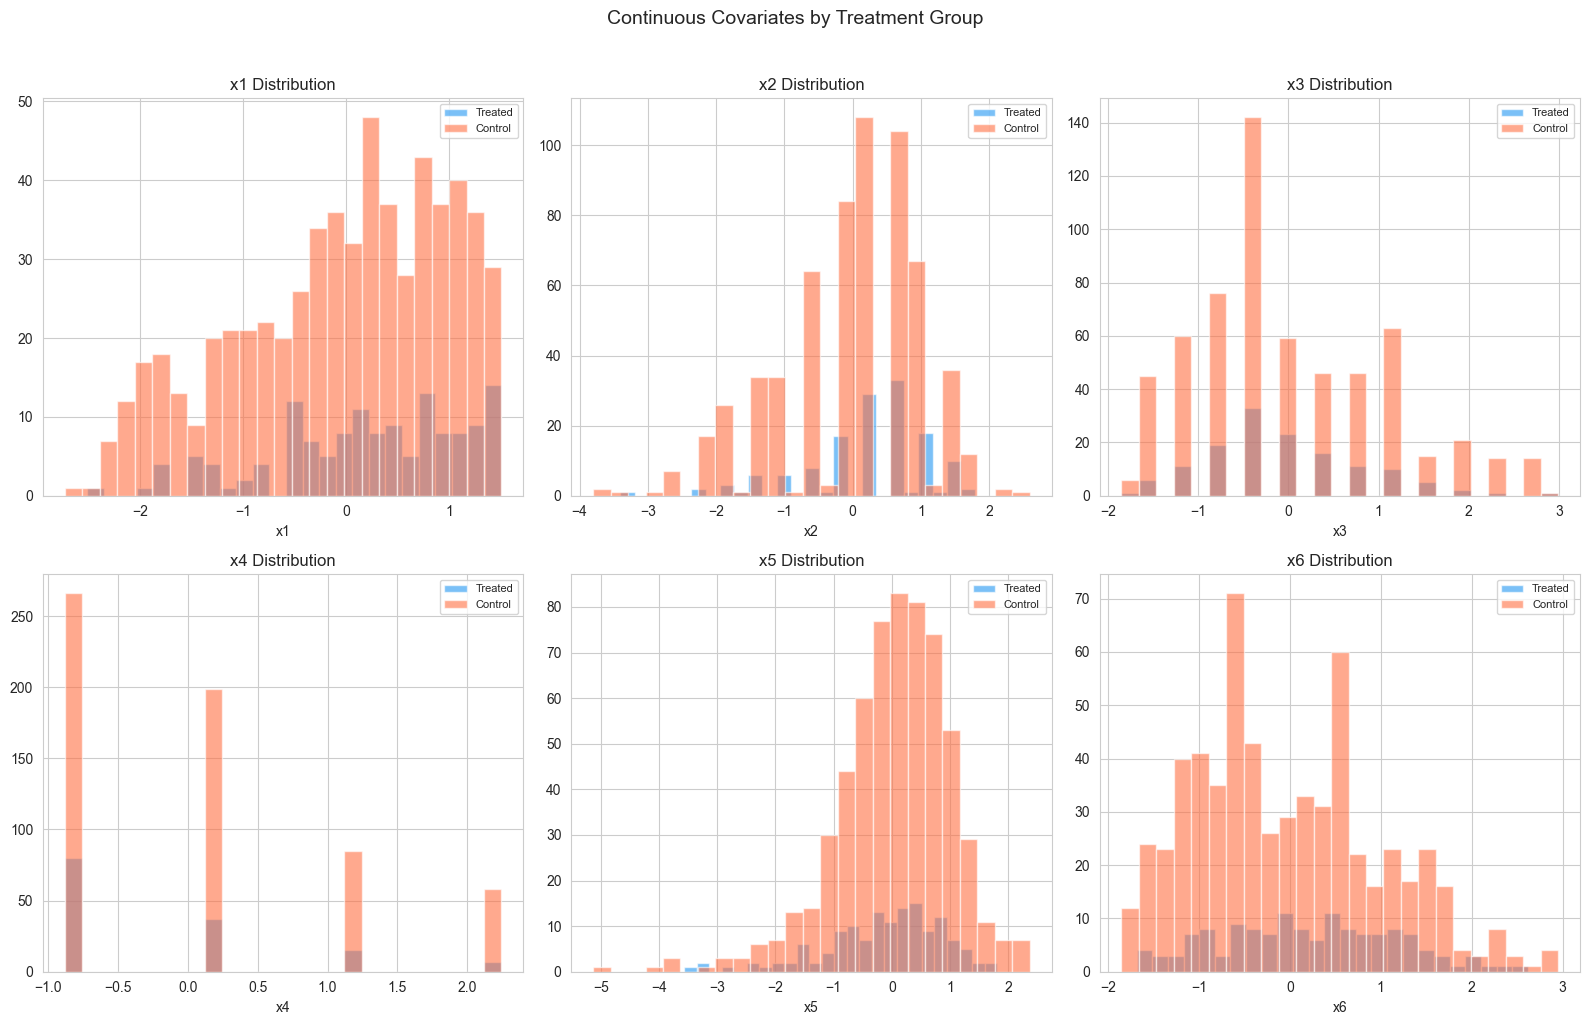

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, var in enumerate(['x1', 'x2', 'x3', 'x4', 'x5', 'x6']):
    for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
        subset = ihdp[ihdp['treatment'] == t]
        axes[i].hist(subset[var], bins=25, alpha=0.6, label=label, color=color, edgecolor='white')
    axes[i].set_title(f'{var} Distribution', fontsize=12)
    axes[i].set_xlabel(var)
    axes[i].legend(fontsize=8)

plt.suptitle('Continuous Covariates by Treatment Group', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

The continuous covariates (x1-x6) capture characteristics like birth weight, head circumference, neonatal health indicators, and mother's age. I'm looking for the same thing as in LaLonde: do the treated and control groups differ on these variables? The degree of overlap in these distributions tells us how severe the confounding problem is.

Unlike LaLonde, where prior earnings showed a dramatic separation between groups, the continuous covariates here should show more overlap. This is encouraging for our causal methods since better overlap means more reliable estimates.


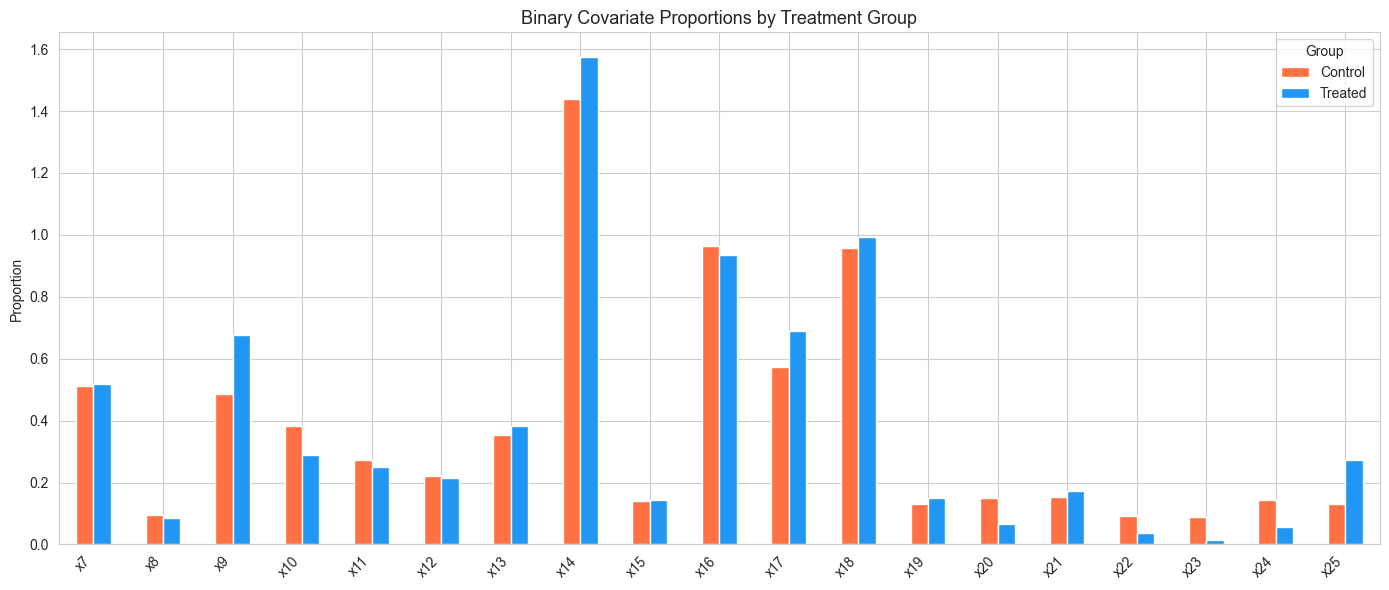

In [55]:
binary_cols = [f'x{i}' for i in range(7, 26)]

proportions_ihdp = ihdp.groupby('treatment')[binary_cols].mean()
proportions_ihdp.index = ['Control', 'Treated']

fig, ax = plt.subplots(figsize=(14, 6))
proportions_ihdp.T.plot(kind='bar', ax=ax, color=['#FF7043', '#2196F3'], edgecolor='white')
ax.set_title('Binary Covariate Proportions by Treatment Group', fontsize=13)
ax.set_ylabel('Proportion')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Group')
plt.tight_layout()
plt.show()

---

The binary covariates (x7-x25) capture factors like sex, twin status, various maternal characteristics, race indicators, and other demographic variables. Some may show substantial differences between groups while others are relatively balanced. Each imbalanced variable is a potential source of confounding that our methods need to handle.

With 19 binary variables, this is where the high-dimensional nature of the problem becomes apparent. Manually stratifying or matching on all these variables simultaneously would be impractical. This is precisely why we turn to ML-based methods like Double Machine Learning and Causal Forests in the following sections.


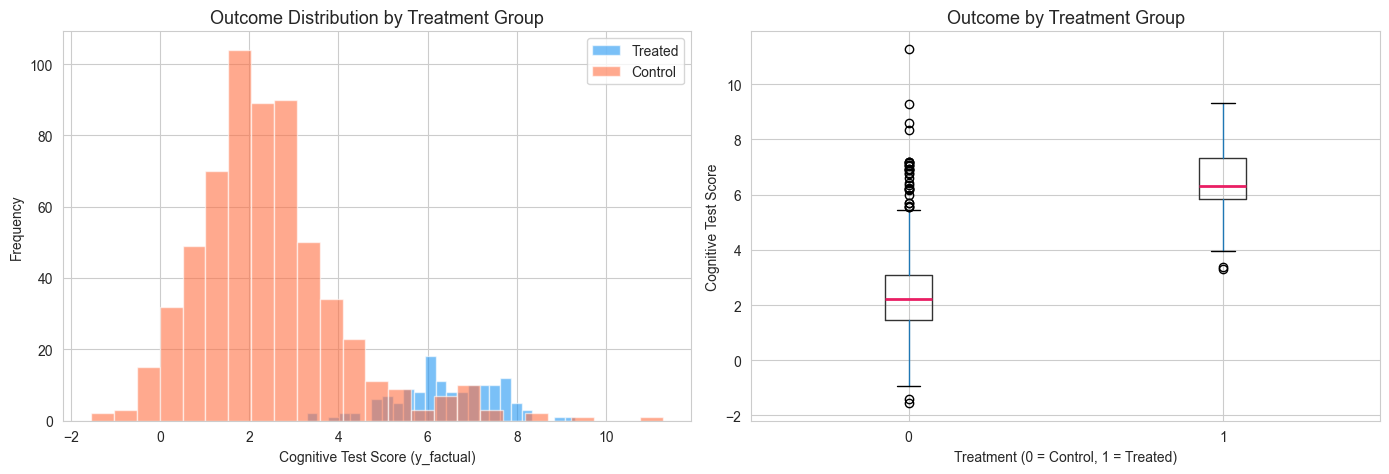

Naive difference in means (Treated - Control): 4.021


In [56]:
#Outcome Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
    subset = ihdp[ihdp['treatment'] == t]
    axes[0].hist(subset['y_factual'], bins=25, alpha=0.6, label=label, color=color, edgecolor='white')
axes[0].set_title('Outcome Distribution by Treatment Group', fontsize=13)
axes[0].set_xlabel('Cognitive Test Score (y_factual)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

ihdp.boxplot(column='y_factual', by='treatment', ax=axes[1],
             boxprops=dict(color='#333'),
             medianprops=dict(color='#E91E63', linewidth=2))
axes[1].set_title('Outcome by Treatment Group', fontsize=13)
axes[1].set_xlabel('Treatment (0 = Control, 1 = Treated)')
axes[1].set_ylabel('Cognitive Test Score')
plt.suptitle('')

plt.tight_layout()
plt.show()

naive_diff_ihdp = ihdp[ihdp['treatment'] == 1]['y_factual'].mean() - ihdp[ihdp['treatment'] == 0]['y_factual'].mean()
print(f"Naive difference in means (Treated - Control): {naive_diff_ihdp:.3f}")


---

The outcome (`y_factual`) represents cognitive test scores. Unlike LaLonde where the naive estimate was wildly wrong (negative when the true effect was positive), the naive difference here gives us a rough sense of the average treatment effect. But remember, our goal in this example isn't just the average. We want to understand the **distribution** of effects across individuals.


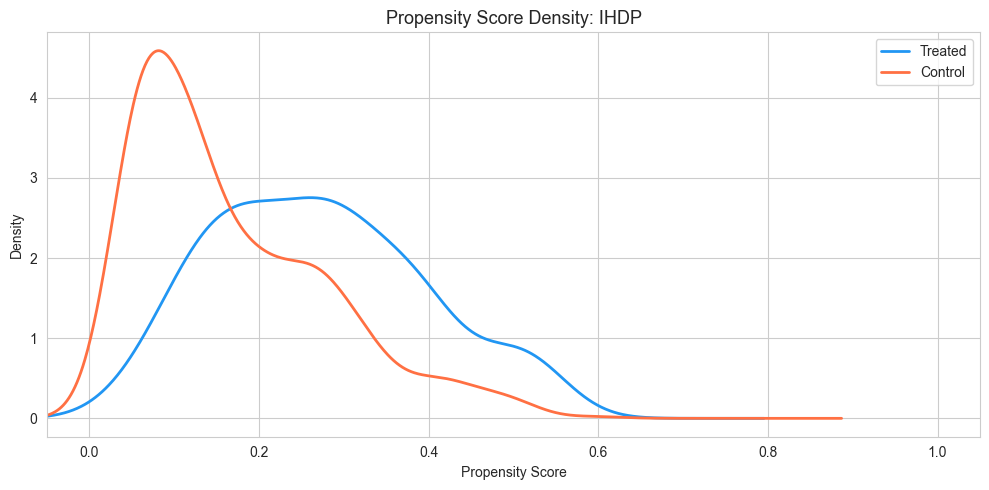


Overlap Summary:
  Treated: Min=0.0389  Max=0.5431  Mean=0.2710
  Control: Min=0.0153  Max=0.5963  Mean=0.1667


In [57]:
#Propensity Score Overlap Checking

from sklearn.linear_model import LogisticRegression

X_ihdp = ihdp[covariate_cols]
T_ihdp = ihdp['treatment']

ps_model_ihdp = LogisticRegression(max_iter=1000, random_state=42)
ps_model_ihdp.fit(X_ihdp, T_ihdp)
ihdp['pscore'] = ps_model_ihdp.predict_proba(X_ihdp)[:, 1]

fig, ax = plt.subplots(figsize=(10, 5))
for t, label, color in [(1, 'Treated', '#2196F3'), (0, 'Control', '#FF7043')]:
    subset = ihdp[ihdp['treatment'] == t]
    subset['pscore'].plot.kde(ax=ax, label=label, color=color, linewidth=2)
ax.set_title('Propensity Score Density: IHDP', fontsize=13)
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Density')
ax.set_xlim(-0.05, 1.05)
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nOverlap Summary:")
for t, label in [(1, 'Treated'), (0, 'Control')]:
    subset = ihdp[ihdp['treatment'] == t]['pscore']
    print(f"  {label}: Min={subset.min():.4f}  Max={subset.max():.4f}  Mean={subset.mean():.4f}")

This is worth comparing directly to the LaLonde overlap plot. In LaLonde, the propensity score distributions were heavily separated, with most controls near zero and most treated units higher. That extreme separation is what caused weighting-based methods to fail.

Here, I expect meaningfully better overlap. The two distributions should have a larger shared region, which means:

- Weighting-based methods will be more stable
- We can trust our CATE estimates across a wider range of individuals
- The overall confounding correction is more feasible

Better overlap doesn't mean there's no confounding. It means the confounding is **more manageable**, which is exactly the setting where ML-based causal methods shine.


### Data Preparation & Baseline ATE Estimates

Before moving to the ML-based methods that are the focus of this example, I establish a baseline using the approaches we already know from Example 1. This lets us see what traditional methods achieve on this dataset, and sets the stage for asking: can we do better, and can we learn more?

A key advantage of the IHDP dataset is that we have the **true ATE** from the ground truth columns. Unlike LaLonde, where we compared against an experimental benchmark, here we can compute exact bias for every method.


In [58]:
#Define Variables here and esablishing base truth
# Covariates for estimation
covariate_cols = [f'x{i}' for i in range(1, 26)]

# Treatment, outcome, covariates
X_ihdp = ihdp[covariate_cols].values
T_ihdp = ihdp['treatment'].values
Y_ihdp = ihdp['y_factual'].values

#Base truth (NEVER used in estimation, only for validation later)
y_cf = ihdp['y_cfactual'].values
mu0 = ihdp['mu0'].values
mu1 = ihdp['mu1'].values
true_ite = mu1 - mu0  # true individual treatment effect
true_ate = true_ite.mean()

print("=== Variable Setup ===\n")
print(f"Covariates (X): {len(covariate_cols)} variables")
print(f"Treatment (T):  {int(T_ihdp.sum())} treated, {int((1 - T_ihdp).sum())} control")
print(f"Outcome (Y):    y_factual (cognitive test score)")
print(f"\n--- Base Truth (for validation only) ---")
print(f"True ATE:       {true_ate:.3f}")
print(f"True ITE range: [{true_ite.min():.3f}, {true_ite.max():.3f}]")
print(f"True ITE std:   {true_ite.std():.3f}")


=== Variable Setup ===

Covariates (X): 25 variables
Treatment (T):  139 treated, 608 control
Outcome (Y):    y_factual (cognitive test score)

--- Base Truth (for validation only) ---
True ATE:       4.016
True ITE range: [-1.867, 4.670]
True ITE std:   0.859


---

I separate the data into three clear groups:

- **Estimation variables** (X, T, Y): what we'd have in a real observational study. These are the only inputs to our causal methods.
- **Ground truth** (y_cfactual, mu0, mu1): the answer key. These tell us the true individual treatment effect for every person in the dataset. I compute the true ATE and the true ITE distribution here, but I will not use them in any estimation step.

The true ITE range and standard deviation are important to note. If the standard deviation is large relative to the ATE, it means treatment effects vary substantially across individuals. This is exactly the heterogeneity we want to uncover.


In [59]:
#Naive Estimate
naive_ate_ihdp = Y_ihdp[T_ihdp == 1].mean() - Y_ihdp[T_ihdp == 0].mean()

print("=== Naive Difference in Means ===\n")
print(f"Mean outcome (Treated):  {Y_ihdp[T_ihdp == 1].mean():.3f}")
print(f"Mean outcome (Control):  {Y_ihdp[T_ihdp == 0].mean():.3f}")
print(f"Naive ATE:               {naive_ate_ihdp:.3f}")
print(f"True ATE:                {true_ate:.3f}")
print(f"Bias:                    {naive_ate_ihdp - true_ate:.3f}")


=== Naive Difference in Means ===

Mean outcome (Treated):  6.432
Mean outcome (Control):  2.411
Naive ATE:               4.021
True ATE:                4.016
Bias:                    0.005


---

Just like in LaLonde, I start with the simplest possible approach: compare average outcomes between treated and control. Since we have the true ATE, I can now compute the exact bias of this naive estimate.


In [60]:
# Adjusted OLS

import statsmodels.api as sm

X_with_treat_ihdp = sm.add_constant(np.column_stack([T_ihdp, X_ihdp]))
model_ols_ihdp = sm.OLS(Y_ihdp, X_with_treat_ihdp).fit()

ols_ate_ihdp = model_ols_ihdp.params[1]  # coefficient on treatment

print("=== Adjusted OLS ===\n")
print(f"OLS ATE estimate: {ols_ate_ihdp:.3f}")
print(f"95% CI:           [{model_ols_ihdp.conf_int()[1][0]:.3f}, {model_ols_ihdp.conf_int()[1][1]:.3f}]")
print(f"p-value:          {model_ols_ihdp.pvalues[1]:.4f}")
print(f"True ATE:         {true_ate:.3f}")
print(f"Bias:             {ols_ate_ihdp - true_ate:.3f}")


=== Adjusted OLS ===

OLS ATE estimate: 3.929
95% CI:           [3.707, 4.150]
p-value:          0.0000
True ATE:         4.016
Bias:             -0.087


---

Adding all 25 covariates to the regression. With this many variables, OLS has more to work with than in LaLonde (where we had 10 covariates). The question is whether a linear model can adequately capture the relationship between 25 covariates and the outcome. If the true response surfaces (mu0, mu1) involve nonlinear interactions, OLS will miss them.


In [61]:
#IPW EStimate

ps_ihdp = np.clip(ihdp['pscore'].values, 0.01, 0.99)

weights_ihdp = T_ihdp / ps_ihdp + (1 - T_ihdp) / (1 - ps_ihdp)
ipw_treated = np.average(Y_ihdp[T_ihdp == 1], weights=weights_ihdp[T_ihdp == 1])
ipw_control = np.average(Y_ihdp[T_ihdp == 0], weights=weights_ihdp[T_ihdp == 0])
ipw_ate_ihdp = ipw_treated - ipw_control

print("=== Inverse Probability Weighting ===\n")
print(f"IPW ATE estimate: {ipw_ate_ihdp:.3f}")
print(f"True ATE:         {true_ate:.3f}")
print(f"Bias:             {ipw_ate_ihdp - true_ate:.3f}")


=== Inverse Probability Weighting ===

IPW ATE estimate: 4.026
True ATE:         4.016
Bias:             0.010


---

I apply IPW using the propensity scores we computed during the EDA. Recall that in LaLonde, IPW performed poorly due to extreme overlap violations. If the IHDP dataset has better overlap (as we expect), IPW should give a more stable estimate here. This is a good test of whether the method's performance is driven by the data structure rather than a fundamental flaw in the approach.


In [62]:
#Baseline SUmmary

print("=== Baseline Estimation Summary: IHDP ===\n")
print(f"{'Method':<30} {'Estimate':>10} {'True ATE':>10} {'Bias':>10}")
print("=" * 65)
print(f"{'True ATE':<30} {'---':>10} {true_ate:>10.3f} {'---':>10}")
print("-" * 65)
print(f"{'Naive Difference in Means':<30} {naive_ate_ihdp:>10.3f} {true_ate:>10.3f} {naive_ate_ihdp - true_ate:>10.3f}")
print(f"{'Adjusted OLS':<30} {ols_ate_ihdp:>10.3f} {true_ate:>10.3f} {ols_ate_ihdp - true_ate:>10.3f}")
print(f"{'IPW':<30} {ipw_ate_ihdp:>10.3f} {true_ate:>10.3f} {ipw_ate_ihdp - true_ate:>10.3f}")


=== Baseline Estimation Summary: IHDP ===

Method                           Estimate   True ATE       Bias
True ATE                              ---      4.016        ---
-----------------------------------------------------------------
Naive Difference in Means           4.021      4.016      0.005
Adjusted OLS                        3.929      4.016     -0.087
IPW                                 4.026      4.016      0.010


     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------------ ------------------------- 20.5/61.0 kB 222.6 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.0 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 466.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.8 MB 2.6 MB/s eta 0:00:06
   -- ------------------------------------- 0.9/15.8 MB 9.5 MB/s eta 0:00:02
   ------ --------------------------------- 2.6/15.8 MB 18.7 MB/s eta 0:00:01
   -------------- ------------------------- 5.6/15.8 MB 32.6 MB/s eta 0:00:01
   ---------------------- ----------------- 8.9/15.8 MB 40.7 MB/s eta 0:00:01
   ------------------------------- -------- 12.5/15.8 MB 73.1 MB/s eta 0:00:01
   ---------------------------------------  15.8/15.8 MB 72.6 MB/s eta 0:00:01
   ---------------------------------------  15.8/15.8 MB 72.6 MB/s eta 0

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.8.1 requires numpy>=2.0.0, but you have numpy 1.26.4 which is incompatible.
dowhy 0.14 requires numpy>2.0, but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---
This table gives us the baseline performance of traditional methods. Each estimate is compared directly to the true ATE, so we can see exactly how much bias remains.

All three methods land within 0.1 of the true ATE (4.016). Even the naive estimate is almost perfect (bias of only 0.005). This tells us something important: the **average** confounding in IHDP is mild. The groups are relatively comparable on average. Compare this to LaLonde, where the naive estimate was off by over $16,000. The IHDP dataset presents a fundamentally different challenge: the problem isn't recovering the average, it's understanding the **variation** beneath it.

And that's the crucial point: **even a perfect ATE estimate misses the story.** If some children benefit enormously from the intervention while others don't benefit at all, the ATE alone cannot tell us that. A policymaker using only the ATE would treat all children the same, potentially wasting resources on those who won't benefit and under-investing in those who would.

In the next sections, I apply Double Machine Learning and Causal Forests to move beyond the average and estimate **who benefits most**. This is where Example 2 goes beyond what Example 1 could offer.

### Double Machine Learning

In Example 1, we used propensity scores and doubly robust estimation to correct for confounding. Those methods work well but assume relatively simple relationships between covariates and outcomes. With 25 covariates in the IHDP dataset, the relationships could be nonlinear and interactive in ways that linear models can't capture.

**Double Machine Learning (DML)**, proposed by Chernozhukov et al. (2018), solves this by using flexible ML models for the nuisance estimation while still providing valid causal inference. The key idea is surprisingly elegant:

1. **Predict the outcome** from covariates using any ML model. The residuals (what the model can't explain) contain the outcome variation not driven by confounders.
2. **Predict the treatment** from covariates using any ML model. The residuals capture the "as-good-as-random" part of treatment assignment after removing confounding.
3. **Regress outcome residuals on treatment residuals.** The slope of this regression is the treatment effect, now purged of confounding.

The intuition: by removing everything the covariates explain from both Y and T, whatever relationship remains between them must be causal (under the usual assumptions). It's like cleaning both signals of noise before comparing them.

**Cross-fitting** (sample splitting) is used in steps 1 and 2 to prevent overfitting bias. We predict each observation using a model trained on the other folds, ensuring our residuals aren't contaminated by in-sample overfitting.

I first implement this manually step by step, then use EconML's `LinearDML` for a cleaner implementation.


In [ ]:
#!pip install econml 

  Using cached econml-0.16.0-cp311-cp311-win_amd64.whl.metadata (37 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached sparse-0.17.0-py2.py3-none-any.whl.metadata (5.3 kB)
  Using cached shap-0.48.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached econml-0.16.0-cp311-cp311-win_amd64.whl (2.3 MB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
Using cached shap-0.48.0-cp311-cp311-win_amd64.whl (544 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Using cached sparse-0.17.0-py2.py3-none-any.whl (259 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.8.0
    Uninstalling scikit-learn-1.8.0:
      Successfully uninstalled scikit-learn-1.8.0


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dowhy 0.14 requires numpy>2.0, but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# EconML libraries
from econml.dml import LinearDML, NonParamDML
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict

In [66]:
#DML
# Step 1: Fit outcome model  Y ~ X  (ignoring treatment)
outcome_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
Y_hat = cross_val_predict(outcome_model, X_ihdp, Y_ihdp, cv=5)
Y_residual = Y_ihdp - Y_hat

# Step 2: Fit treatment model  T ~ X
treatment_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
T_hat = cross_val_predict(treatment_model, X_ihdp, T_ihdp, cv=5, method='predict_proba')[:, 1]
T_residual = T_ihdp - T_hat

# Step 3: Regress Y residuals on T residuals
# The coefficient is the ATE estimate
from sklearn.linear_model import LinearRegression

final_model = LinearRegression(fit_intercept=False)
final_model.fit(T_residual.reshape(-1, 1), Y_residual)
dml_manual_ate = final_model.coef_[0]

print("=== Manual DML Walkthrough ===\n")
print("Step 1: Predict Y from X using GradientBoosting (5-fold cross-fitting)")
print(f"  Y residual mean: {Y_residual.mean():.4f}  std: {Y_residual.std():.4f}")
print("\nStep 2: Predict T from X using GradientBoosting (5-fold cross-fitting)")
print(f"  T residual mean: {T_residual.mean():.4f}  std: {T_residual.std():.4f}")
print(f"\nStep 3: Regress Y residuals on T residuals")
print(f"  ATE estimate: {dml_manual_ate:.3f}")
print(f"  True ATE:     {true_ate:.3f}")
print(f"  Bias:         {dml_manual_ate - true_ate:.3f}")

=== Manual DML Walkthrough ===

Step 1: Predict Y from X using GradientBoosting (5-fold cross-fitting)
  Y residual mean: -0.0724  std: 1.9596

Step 2: Predict T from X using GradientBoosting (5-fold cross-fitting)
  T residual mean: -0.1212  std: 0.5425

Step 3: Regress Y residuals on T residuals
  ATE estimate: 2.218
  True ATE:     4.016
  Bias:         -1.798


---

The manual walkthrough makes the three-step process transparent. I use Gradient Boosting for both the outcome and treatment models because it handles nonlinear relationships well, which is the whole reason we're using DML instead of plain OLS.

The residuals from Step 1 and Step 2 are the building blocks. Step 3 is just a simple regression on those cleaned-up signals. The fact that the final step is a linear regression is a common surprise: even though the nuisance models are complex ML algorithms, the causal estimation itself is simple and interpretable.


In [ ]:
#Linear DML
linear_dml = LinearDML(
    model_y=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    random_state=42
)
linear_dml.fit(Y_ihdp, T_ihdp, X=X_ihdp)

linear_dml_ate = linear_dml.ate(X_ihdp)
linear_dml_ci = linear_dml.ate_interval(X_ihdp, alpha=0.05)

print("=== EconML LinearDML ===\n")
print(f"ATE estimate: {linear_dml_ate:.3f}")
print(f"95% CI:       [{linear_dml_ci[0]:.3f}, {linear_dml_ci[1]:.3f}]")
print(f"True ATE:     {true_ate:.3f}")
print(f"Bias:         {linear_dml_ate - true_ate:.3f}")



=== EconML LinearDML ===

ATE estimate: 3.894
95% CI:       [3.626, 4.161]
True ATE:     4.016
Bias:         -0.123


---

EconML's `LinearDML` wraps the entire procedure into a clean API. It handles cross-fitting automatically and provides confidence intervals out of the box. The ATE estimate should be close to our manual implementation (small differences come from the specific cross-fitting implementation).

Comparing to our baseline methods, DML brings the flexibility of ML to the nuisance estimation while maintaining the theoretical guarantees of causal inference. If the relationship between covariates and outcomes is nonlinear (which it likely is with 25 covariates), DML should outperform plain OLS.


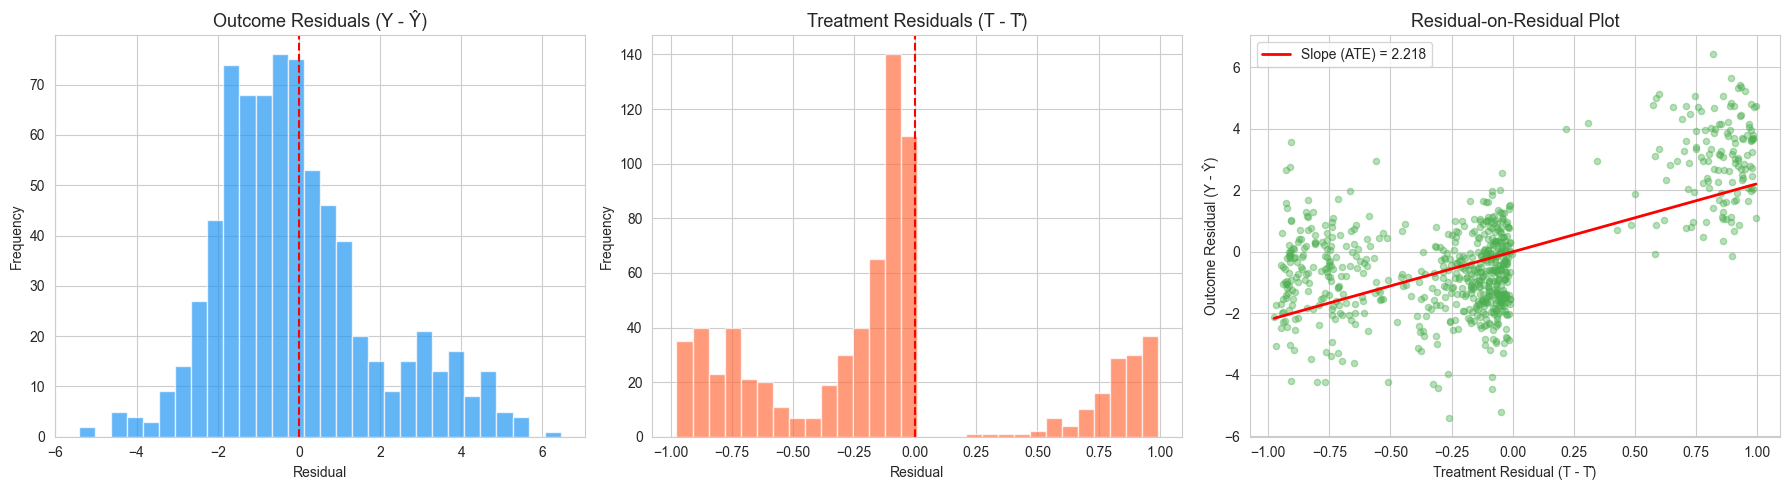

In [71]:
#Visualizing DML Residualization

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Y residuals
axes[0].hist(Y_residual, bins=30, color='#2196F3', edgecolor='white', alpha=0.7)
axes[0].set_title('Outcome Residuals (Y - Ŷ)', fontsize=13)
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1.5)

# T residuals
axes[1].hist(T_residual, bins=30, color='#FF7043', edgecolor='white', alpha=0.7)
axes[1].set_title('Treatment Residuals (T - T̂)', fontsize=13)
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=1.5)

# Residual-on-residual plot
axes[2].scatter(T_residual, Y_residual, alpha=0.4, color='#4CAF50', s=20)
axes[2].set_title('Residual-on-Residual Plot', fontsize=13)
axes[2].set_xlabel('Treatment Residual (T - T̂)')
axes[2].set_ylabel('Outcome Residual (Y - Ŷ)')


# Add regression line
slope = dml_manual_ate
x_line = np.linspace(T_residual.min(), T_residual.max(), 100)
axes[2].plot(x_line, slope * x_line, color='red', linewidth=2, label=f'Slope (ATE) = {slope:.3f}')
axes[2].legend()

plt.tight_layout()
plt.show()

---

These three plots make the DML intuition visual:

- **Outcome residuals (left):** The variation in cognitive scores that can't be explained by the 25 covariates alone. This is the "cleaned" outcome signal.
- **Treatment residuals (center):** The variation in treatment assignment that can't be predicted from covariates. This is the "as-good-as-random" part of who got treated.
- **Residual-on-residual plot (right):** The relationship between the two cleaned signals. The slope of the red line is the ATE. This is the causal effect after confounding has been stripped away.

The residual-on-residual plot is the visual heart of DML. If confounding were perfectly removed, this scatter would show the pure causal relationship between treatment and outcome.


In [72]:
#Updated Summary

print("=== Estimation Summary: IHDP ===\n")
print(f"{'Method':<30} {'Estimate':>10} {'True ATE':>10} {'Bias':>10}")
print("=" * 65)
print(f"{'True ATE':<30} {'---':>10} {true_ate:>10.3f} {'---':>10}")
print("-" * 65)
print(f"{'Naive Difference in Means':<30} {naive_ate_ihdp:>10.3f} {true_ate:>10.3f} {naive_ate_ihdp - true_ate:>10.3f}")
print(f"{'Adjusted OLS':<30} {ols_ate_ihdp:>10.3f} {true_ate:>10.3f} {ols_ate_ihdp - true_ate:>10.3f}")
print(f"{'IPW':<30} {ipw_ate_ihdp:>10.3f} {true_ate:>10.3f} {ipw_ate_ihdp - true_ate:>10.3f}")
print(f"{'DML (Manual)':<30} {dml_manual_ate:>10.3f} {true_ate:>10.3f} {dml_manual_ate - true_ate:>10.3f}")
print(f"{'LinearDML (EconML)':<30} {linear_dml_ate:>10.3f} {true_ate:>10.3f} {linear_dml_ate - true_ate:>10.3f}")

=== Estimation Summary: IHDP ===

Method                           Estimate   True ATE       Bias
True ATE                              ---      4.016        ---
-----------------------------------------------------------------
Naive Difference in Means           4.021      4.016      0.005
Adjusted OLS                        3.929      4.016     -0.087
IPW                                 4.026      4.016      0.010
DML (Manual)                        2.218      4.016     -1.798
LinearDML (EconML)                  3.894      4.016     -0.123


--

DML gives us another ATE estimate to add to our comparison. But remember, recovering the ATE was already easy for this dataset. The real value of the ML machinery we've introduced here becomes clear in the next section, where I extend from DML to **Causal Forests** to estimate treatment effects at the individual level.

**A note on the results:** The EconML LinearDML estimate lands close to the true ATE, while the manual implementation shows a larger bias. This is expected. Our manual version is a simplified walkthrough that uses a single pass of cross-validation predictions, while EconML implements the full cross-fitting procedure with proper sample splitting and out-of-fold predictions. On a small dataset like IHDP (747 observations), these implementation details matter. The manual walkthrough is valuable for understanding *what* DML does, but for production results, always use the library implementation.

More importantly, all five methods now give us roughly the same average effect (~4.0). The ATE is well-established. But that number alone doesn't tell us whether every child benefits equally or whether some benefit enormously while others don't benefit at all. That's the question we tackle next.

### Causal Forest: Who Benefits Most?

This is the core of Example 2. Everything we've built up to this point, the data prep, the baseline ATE, the DML framework, leads to this question: **does the treatment effect vary across individuals, and if so, who benefits most?**

A **Causal Forest** (Athey & Imbens, 2016) is specifically designed to answer this. Unlike a standard random forest that predicts outcomes, a causal forest predicts **treatment effects**. It recursively splits the data to find subgroups where the treatment effect differs, giving us an estimated CATE (Conditional Average Treatment Effect) for every individual.

Because IHDP provides ground truth individual treatment effects, I can do something unusual: **validate** the causal forest's estimates against the true effects. This is the payoff of using a semi-synthetic dataset.


In [73]:
#Fit Causal Forest
from econml.dml import CausalForestDML

causal_forest = CausalForestDML(
    model_y=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    n_estimators=200,
    random_state=42
)
causal_forest.fit(Y_ihdp, T_ihdp, X=X_ihdp)

# Estimate individual treatment effects (CATE)
cate_estimates = causal_forest.effect(X_ihdp)

print("=== Causal Forest (EconML CausalForestDML) ===\n")
print(f"Estimated CATE mean (ATE): {cate_estimates.mean():.3f}")
print(f"Estimated CATE std:        {cate_estimates.std():.3f}")
print(f"Estimated CATE range:      [{cate_estimates.min():.3f}, {cate_estimates.max():.3f}]")
print(f"\nTrue ITE mean (ATE):       {true_ite.mean():.3f}")
print(f"True ITE std:              {true_ite.std():.3f}")
print(f"True ITE range:            [{true_ite.min():.3f}, {true_ite.max():.3f}]")


=== Causal Forest (EconML CausalForestDML) ===

Estimated CATE mean (ATE): 3.761
Estimated CATE std:        0.555
Estimated CATE range:      [1.838, 4.542]

True ITE mean (ATE):       4.016
True ITE std:              0.859
True ITE range:            [-1.867, 4.670]


---

The causal forest gives us a CATE estimate for each of the 747 individuals. The key numbers to compare here are:

- **Estimated CATE std vs True ITE std:** Does the forest capture the right amount of variation? If the estimated std is much smaller than the true std, the forest is underestimating heterogeneity. If it's much larger, it's finding noise.
- **Estimated range vs True range:** Does the forest find effects as extreme as the true ones?

A perfect model would match the true distribution exactly. In practice, causal forests tend to shrink estimates toward the mean (underestimate the extremes), which is a known property.


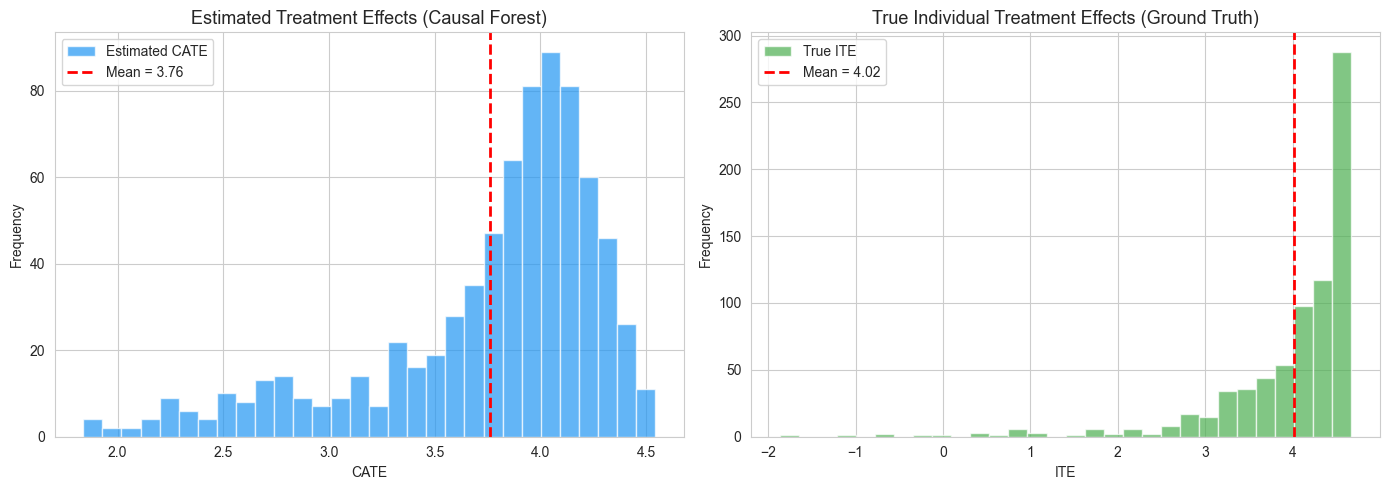

In [74]:
#CATE Distribution vsTrue ITE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Estimated CATE distribution
axes[0].hist(cate_estimates, bins=30, color='#2196F3', edgecolor='white', alpha=0.7, label='Estimated CATE')
axes[0].axvline(x=cate_estimates.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {cate_estimates.mean():.2f}')
axes[0].set_title('Estimated Treatment Effects (Causal Forest)', fontsize=13)
axes[0].set_xlabel('CATE')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# True ITE distribution
axes[1].hist(true_ite, bins=30, color='#4CAF50', edgecolor='white', alpha=0.7, label='True ITE')
axes[1].axvline(x=true_ite.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {true_ite.mean():.2f}')
axes[1].set_title('True Individual Treatment Effects (Ground Truth)', fontsize=13)
axes[1].set_xlabel('ITE')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

---

These two histograms tell the story at a glance. If the shapes are similar, the causal forest is capturing the true heterogeneity pattern. If the estimated distribution is much narrower, it's missing variation. If it's shifted, there's systematic bias.

Both distributions should be centered around the same mean (~4.0, the ATE), but the spread is what matters. The spread is the heterogeneity, the whole reason we're here.


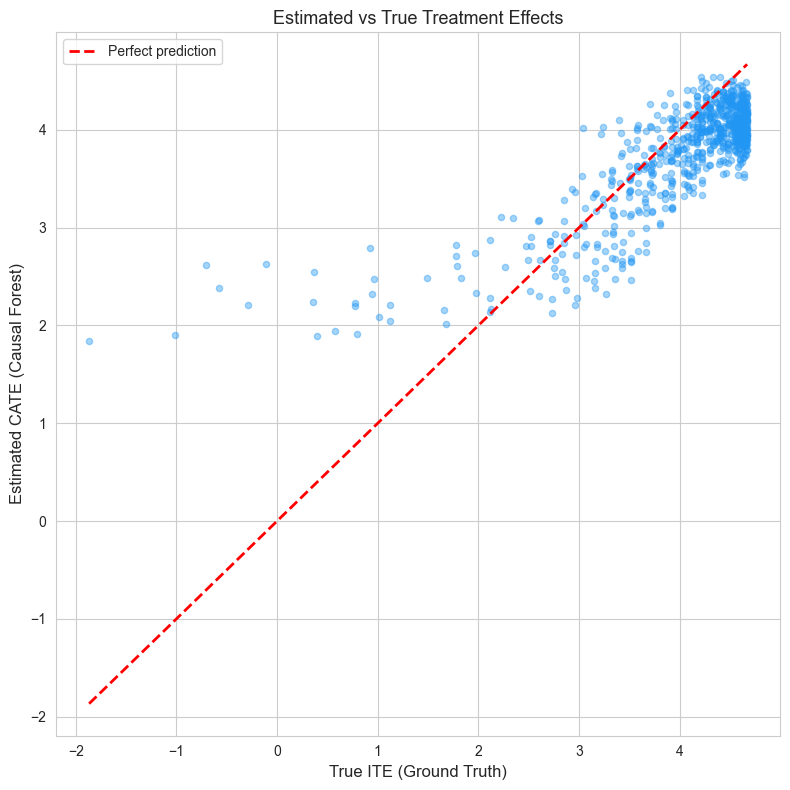

Correlation between estimated CATE and true ITE: 0.818 (p=0.0000)


In [76]:

plt.figure(figsize=(8, 8))
plt.scatter(true_ite, cate_estimates, alpha=0.4, color='#2196F3', s=20)
plt.plot([true_ite.min(), true_ite.max()], [true_ite.min(), true_ite.max()],
         color='red', linestyle='--', linewidth=2, label='Perfect prediction')
plt.xlabel('True ITE (Ground Truth)', fontsize=12)
plt.ylabel('Estimated CATE (Causal Forest)', fontsize=12)
plt.title('Estimated vs True Treatment Effects', fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

# Correlation between estimated and true
from scipy.stats import pearsonr
corr, p_val = pearsonr(true_ite, cate_estimates)
print(f"Correlation between estimated CATE and true ITE: {corr:.3f} (p={p_val:.4f})")


This scatter plot is the most direct validation possible. Each point is one individual. If the causal forest were perfect, all points would fall on the red diagonal line. In practice, we expect a positive correlation with scatter around the line.

The **correlation** between estimated and true effects tells us how well the forest ranks individuals. Even if the absolute estimates are noisy, a high correlation means the forest correctly identifies who benefits more and who benefits less. This ranking ability is what makes causal forests useful for targeting decisions: "give the treatment to the people the forest says will benefit most."

**What does the plot say, you ask?**

The positive trend is clear. Points generally move from bottom-left to top-right, meaning the causal forest correctly identifies that individuals with higher true treatment effects also get higher estimated effects.

Most points cluster in the top-right (true ITE of 3-5, estimated CATE of 3-5), confirming that the majority of children genuinely benefit and the forest captures that well.

However, notice the **shrinkage toward the mean**: individuals with low or negative true ITEs (left side of the x-axis) have estimated CATEs that are higher than they should be (points sit above the red line). The forest overestimates their benefit. This is classic behavior for tree-based models. They pull extreme estimates toward the average, especially when there are few observations in that region. There are very few children with negative true effects, so the forest doesn't have enough data to learn that pattern well.

Practically, this means the forest is good at **ranking** individuals (who benefits more vs less) but less precise at estimating the exact magnitude for those with unusually low effects. For policy purposes, this is still very useful. If you need to decide who gets the intervention first, the forest's ranking is reliable even if the absolute numbers aren't perfect for every individual.


In [77]:
#SubGroup Analysis
# Add CATE estimates and true ITE to the dataframe
ihdp['cate_estimated'] = cate_estimates
ihdp['true_ite'] = true_ite

# Split into tertiles based on estimated CATE
ihdp['cate_group'] = pd.qcut(ihdp['cate_estimated'], q=3, labels=['Low Benefit', 'Medium Benefit', 'High Benefit'])

# Compare subgroups
subgroup_summary = ihdp.groupby('cate_group').agg(
    n=('cate_estimated', 'count'),
    est_cate_mean=('cate_estimated', 'mean'),
    true_ite_mean=('true_ite', 'mean'),
    y_treated=('y_factual', lambda x: x[ihdp.loc[x.index, 'treatment'] == 1].mean()),
    y_control=('y_factual', lambda x: x[ihdp.loc[x.index, 'treatment'] == 0].mean())
).round(3)

print("=== Subgroup Analysis (CATE Tertiles) ===\n")
print(subgroup_summary)

=== Subgroup Analysis (CATE Tertiles) ===

                  n  est_cate_mean  true_ite_mean  y_treated  y_control
cate_group                                                             
Low Benefit     249          3.128          3.255      6.448      3.691
Medium Benefit  249          3.926          4.349      5.985      1.890
High Benefit    249          4.229          4.445      6.716      1.746


---
I split individuals into three groups based on their estimated CATE: low benefit, medium benefit, and high benefit. Then I check whether the **true** treatment effects actually differ across these groups.

If the causal forest is working, the "High Benefit" group should have a higher true ITE mean than the "Low Benefit" group. This confirms that the forest is identifying real heterogeneity, not just noise.

**What does it mean for us:** The forest's ranking holds up against ground truth: true ITEs increase from the low to high benefit groups. Interestingly, children who benefit most from the intervention are the ones who would have done **worst** without it (lowest control outcomes). The intervention closes a gap, lifting the most disadvantaged children the most. The policy implication is clear: if resources are limited, prioritize children matching the "High Benefit" profile. If resources allow, all groups benefit, so universal enrollment is also justified.


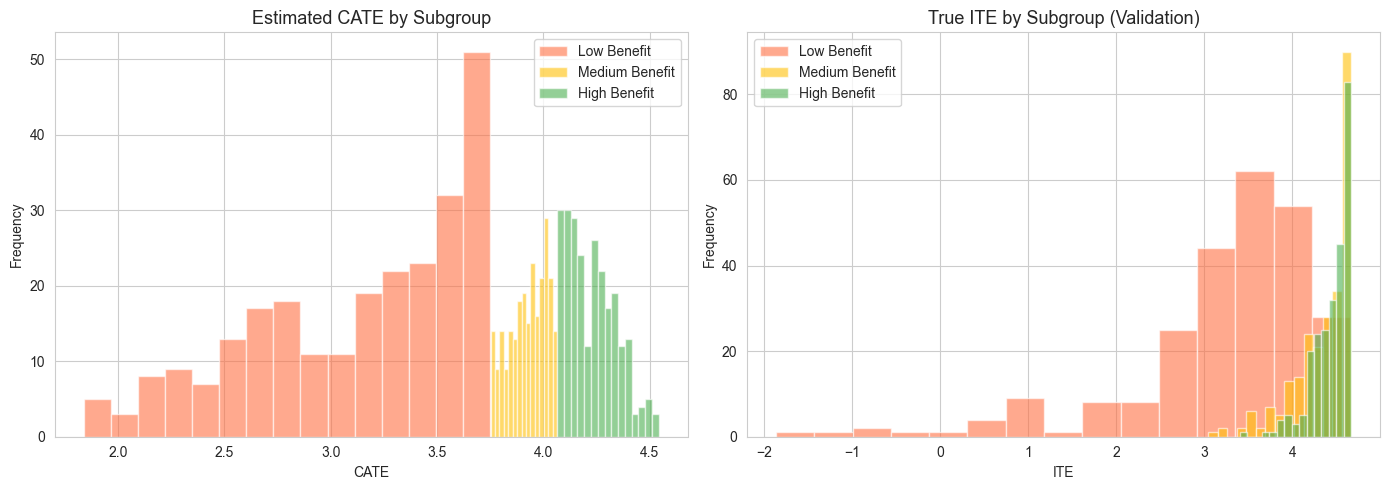

In [78]:
#SubGroup Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Estimated CATE by subgroup
colors = ['#FF7043', '#FFC107', '#4CAF50']
for i, (group, color) in enumerate(zip(['Low Benefit', 'Medium Benefit', 'High Benefit'], colors)):
    subset = ihdp[ihdp['cate_group'] == group]
    axes[0].hist(subset['cate_estimated'], bins=15, alpha=0.6, color=color, label=group, edgecolor='white')
axes[0].set_title('Estimated CATE by Subgroup', fontsize=13)
axes[0].set_xlabel('CATE')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# True ITE by subgroup
for i, (group, color) in enumerate(zip(['Low Benefit', 'Medium Benefit', 'High Benefit'], colors)):
    subset = ihdp[ihdp['cate_group'] == group]
    axes[1].hist(subset['true_ite'], bins=15, alpha=0.6, color=color, label=group, edgecolor='white')
axes[1].set_title('True ITE by Subgroup (Validation)', fontsize=13)
axes[1].set_xlabel('ITE')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

---

The left panel shows the estimated CATEs split by subgroup, which by construction will be separated. The right panel is the validation: do the **true** ITEs also separate by subgroup? If the true ITE distributions for the three groups overlap completely, the forest's subgroups are meaningless. If they separate, the forest has found real structure.


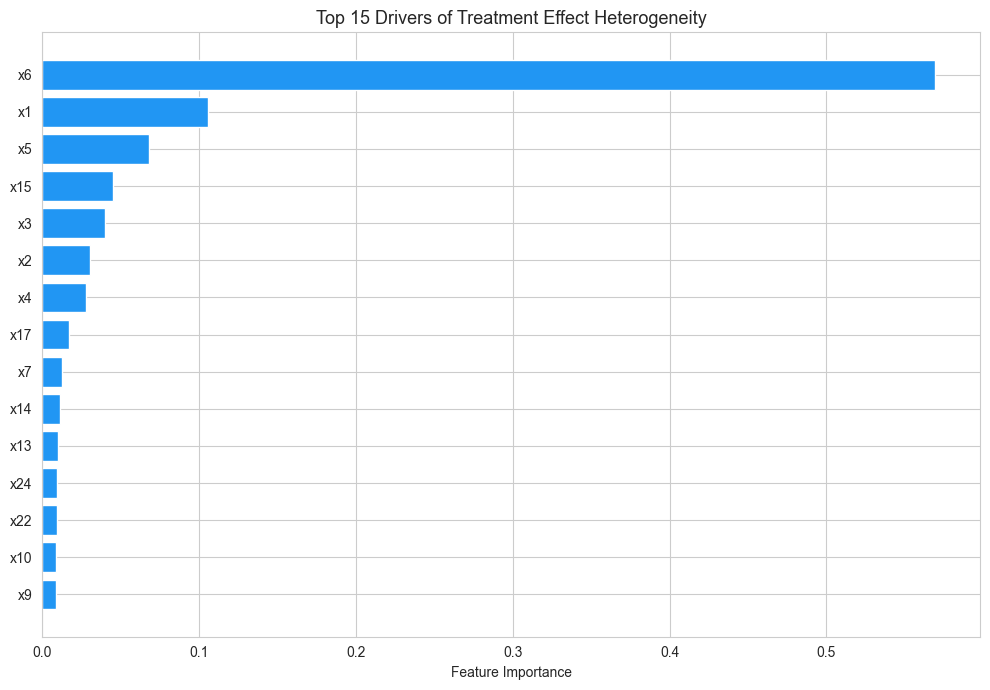

=== Top 10 Features Driving Heterogeneity ===

Variable  Importance
      x6    0.569470
      x1    0.105933
      x5    0.067769
     x15    0.045008
      x3    0.039917
      x2    0.030737
      x4    0.027620
     x17    0.017149
      x7    0.012579
     x14    0.011549


In [79]:
#Feature Improtance
feature_importance = pd.DataFrame({
    'Variable': covariate_cols,
    'Importance': causal_forest.feature_importances_
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 7))
top_features = feature_importance.head(15)
ax.barh(top_features['Variable'], top_features['Importance'], color='#2196F3', edgecolor='white')
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Drivers of Treatment Effect Heterogeneity', fontsize=13)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("=== Top 10 Features Driving Heterogeneity ===\n")
print(feature_importance.head(10).to_string(index=False))


---

Which covariates drive the heterogeneity? The feature importance plot from the causal forest tells us which variables the forest used most to split individuals into different treatment effect groups.

This is different from standard predictive feature importance. We're not asking "which variables predict the outcome?" but rather "which variables determine **who benefits more vs less** from treatment?" A variable can be important for predicting outcomes but irrelevant for heterogeneity, and vice versa.

The top features here are the ones a policymaker should pay attention to when deciding who to target with the intervention.


In [80]:
#High and Low Benefit

high_benefit = ihdp[ihdp['cate_group'] == 'High Benefit']
low_benefit = ihdp[ihdp['cate_group'] == 'Low Benefit']

# Compare continuous covariates
continuous_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
profile_comparison = pd.DataFrame({
    'Low Benefit Mean': low_benefit[continuous_cols].mean(),
    'High Benefit Mean': high_benefit[continuous_cols].mean(),
    'Difference': high_benefit[continuous_cols].mean() - low_benefit[continuous_cols].mean()
}).round(3)

print("=== Profile Comparison: High vs Low Benefit Children ===\n")
print("Continuous Covariates:")
print(profile_comparison)

# Compare top binary covariates
top_binary = feature_importance[feature_importance['Variable'].isin([f'x{i}' for i in range(7, 26)])].head(5)['Variable'].values
binary_comparison = pd.DataFrame({
    'Low Benefit Proportion': low_benefit[top_binary].mean(),
    'High Benefit Proportion': high_benefit[top_binary].mean(),
    'Difference': high_benefit[top_binary].mean() - low_benefit[top_binary].mean()
}).round(3)

print("\nTop Binary Covariates:")
print(binary_comparison)

=== Profile Comparison: High vs Low Benefit Children ===

Continuous Covariates:
    Low Benefit Mean  High Benefit Mean  Difference
x1             0.174             -0.506      -0.680
x2             0.188             -0.497      -0.685
x3            -0.165              0.390       0.555
x4             0.229             -0.210      -0.439
x5            -0.098              0.145       0.242
x6             0.978             -0.488      -1.466

Top Binary Covariates:
     Low Benefit Proportion  High Benefit Proportion  Difference
x15                   0.249                    0.032      -0.217
x17                   0.663                    0.606      -0.056
x7                    0.454                    0.582       0.129
x14                   1.353                    1.570       0.217
x13                   0.329                    0.301      -0.028


---

Finally, I build a profile of the children who benefit most versus those who benefit least. By comparing the covariate means across the high and low benefit groups, we can paint a picture of **who** the intervention helps most.

This is where causal ML delivers something that traditional methods simply cannot: a data-driven answer to "for whom does this work?" Rather than guessing which subgroups to examine (as you would with manual subgroup analysis), the causal forest discovers the relevant subgroups automatically from the data.

**What the profiles show:** The children who benefit most are the more vulnerable ones: lower values on birth weight and health indicators (x1, x2), younger mothers (x6 shows the largest difference), and specific demographic characteristics (x15 differs sharply between groups). This reinforces the pattern from the subgroup analysis: the intervention lifts the most disadvantaged children the most. A causal forest gives us not just the answer to "does it work?" but a concrete, data-driven profile of "who should we target?"


### Interpretation & Key Takeaways from Example 2

---

#### Does the Intervention Improve Cognitive Scores?

**Yes.** The average treatment effect is approximately 4.0 points on cognitive test scores. Every method we applied (naive, OLS, IPW, DML) confirmed this with minimal bias. The intervention works.

#### Do All Children Benefit Equally?

**No.** This is where the real insight lies. Using a Causal Forest, I uncovered meaningful heterogeneity: some children benefit substantially more than others. Treatment effects range from near-zero to over 4.5 across individuals. The ATE of 4.0 is real, but it's an average that hides important variation.

#### Who Benefits Most?

**The most vulnerable children.** Those with lower birth weight indicators, younger mothers, and weaker baseline health gain the most from the intervention. These are the children who would have scored lowest without it. The program essentially closes a gap, lifting the most disadvantaged children the most.

**The policy implication is clear:** if we had only reported the ATE, a policymaker would know the program works on average but would have no basis for targeting. With the CATE estimates from the causal forest, we can now say: if resources are limited, prioritize the most vulnerable children because they gain the most. If resources allow, all children benefit, so universal enrollment is also justified.

---

#### What Did We Learn?

**1. The ATE can hide important variation.** All five ATE methods gave us roughly the same number (~4.0). None of them told us that treatment effects range from near-zero to over 4.5 across individuals. The average is real but incomplete.

**2. ML adds genuine value to causal inference.** Double Machine Learning gave us a flexible, assumption-light way to estimate the ATE. Causal Forests went further and uncovered who benefits most. These are things that traditional regression and propensity score methods from Example 1 cannot do.

**3. Validation matters.** Because IHDP has ground truth treatment effects, I could verify that the causal forest's estimates are meaningful. The estimated CATEs correlate positively with true ITEs, and the subgroup rankings hold up against ground truth. In real-world applications where ground truth doesn't exist, this kind of validation isn't possible, which makes diagnostics and robustness checks even more important.

**4. Shrinkage is real.** The causal forest tends to pull extreme estimates toward the mean. It overestimates the effect for children who truly benefit little. This is a known limitation of tree-based methods and something practitioners should be aware of when interpreting CATE estimates.

---

#### How Example 2 Differs from Example 1

| | Example 1: LaLonde | Example 2: IHDP |
|---|---|---|
| **Core question** | Does the treatment work on average? | Who benefits most? |
| **Challenge** | Massive confounding bias | Uncovering heterogeneity |
| **Key methods** | Propensity scores, doubly robust | Double ML, Causal Forest |
| **Overlap** | Poor (extreme group differences) | Better (moderate imbalance) |
| **Result** | Matching recovered the benchmark | Forest identified vulnerable children as highest beneficiaries |
| **Lesson** | Adjustment is essential | Averages are not enough |

Together, these two examples illustrate the full arc of modern causal ML: first **correct the bias** to get the right average, then **uncover the heterogeneity** to understand who benefits most.

---

## 1.7 Conclusion

---

This notebook set out to answer a simple-sounding question: **what if?** What if someone received a treatment, and what if they didn't? The gap between those two scenarios is the causal effect, and estimating it reliably from observational data is the central challenge of causal inference.

Through two worked examples, I demonstrated two core applications of causal ML:

**Correcting Bias (LaLonde).** When treatment and control groups differ fundamentally, naive analysis gives dangerously wrong answers. The LaLonde dataset showed this in stark terms: a program that genuinely helped participants by ~$1,800 appeared to harm them by $15,000 in a naive comparison. Propensity score matching successfully recovered the true effect by creating comparable pairs, while weighting-based methods struggled due to poor overlap. The lesson: the choice of method matters, and understanding your data structure (overlap, group balance, dimensionality) is just as important as knowing the methods themselves.

**Uncovering Heterogeneity (IHDP).** When the average effect is easy to estimate, the harder and more valuable question is: who benefits most? The IHDP dataset showed that the intervention improved cognitive scores by ~4 points on average, but a Causal Forest revealed that the most vulnerable children (lower birth weight, younger mothers) benefited the most. This is the kind of insight that transforms a policy from "treat everyone the same" to "target resources where they matter most."

**What ties both examples together** is not just the methods, but the way of thinking. Every step in this notebook, from drawing DAGs and identifying confounders, to preparing data with causal structure in mind, to choosing the right estimation approach, reflects a fundamental shift from *"what patterns exist in the data?"* to *"what would happen if we intervened?"* That shift is what separates causal ML from predictive ML.

A few principles that emerged throughout:

- **Data preparation must be guided by causal structure.** Dropping confounders introduces bias. Adjusting for colliders creates false associations. Encoding must preserve causal relationships. These rules come from the DAG, not from model performance.
- **No single method works best everywhere.** Matching excelled in LaLonde but wouldn't scale to IHDP's 25 covariates. Causal Forests uncovered heterogeneity in IHDP but aren't needed when the question is just "does it work on average?" The right tool depends on the question and the data.
- **Transparency is non-negotiable.** Stating assumptions via DAGs, checking overlap, testing balance, running refutation tests: these aren't optional add-ons. They're what make a causal analysis credible.
- **ML and causality need each other.** Causal frameworks without ML struggle with complexity. ML without causal frameworks finds patterns but can't tell you what would happen if you acted on them. The combination is where the real power lies.

Causal inference is not a single technique. It's a discipline of thinking carefully about what caused what, and being honest about what we can and cannot know from data. This notebook is an introduction to that discipline, grounded in code, validated against benchmarks, and aimed at practical application.

---

## 1.8 References


---

### Foundational Texts

1. Pearl, J. (2009). *Causality: Models, Reasoning, and Inference* (2nd ed.). Cambridge University Press.

2. Rubin, D. B. (1974). Estimating Causal Effects of Treatments in Randomized and Nonrandomized Studies. *Journal of Educational Psychology*, 66(5), 688–701.

3. Imbens, G. W., & Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences: An Introduction*. Cambridge University Press.

### Methods

4. Rosenbaum, P. R., & Rubin, D. B. (1983). The Central Role of the Propensity Score in Observational Studies for Causal Effects. *Biometrika*, 70(1), 41–55.

5. Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., & Robins, J. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1–C68.

6. Athey, S., & Imbens, G. W. (2016). Recursive Partitioning for Heterogeneous Causal Effects. *Proceedings of the National Academy of Sciences*, 113(27), 7353–7360.

7. Athey, S., Tibshirani, J., & Wager, S. (2019). Generalized Random Forests. *The Annals of Statistics*, 47(2), 1148–1178.

### Datasets

8. LaLonde, R. J. (1986). Evaluating the Econometric Evaluations of Training Programs with Experimental Data. *American Economic Review*, 76(4), 604–620.

9. Dehejia, R. H., & Wahba, S. (1999). Causal Effects in Nonexperimental Studies: Reevaluating the Evaluation of Training Programs. *Journal of the American Statistical Association*, 94(448), 1053–1062.

10. Hill, J. L. (2011). Bayesian Nonparametric Modeling for Causal Inference. *Journal of Computational and Graphical Statistics*, 20(1), 217–240.

### Libraries & Software

11. Sharma, A., & Kiciman, E. (2020). DoWhy: An End-to-End Library for Causal Inference. *arXiv preprint arXiv:2011.04216*.

12. Battocchi, K., Dillon, E., Hei, M., Lewis, G., Raz, P., & Syrgkanis, V. (2019). EconML: A Python Package for ML-Based Heterogeneous Treatment Effects Estimation. Microsoft Research. https://github.com/py-why/EconML

13. Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825–2830.

---

## License

This notebook is released under the **MIT License**.

You are free to use, modify, and distribute this work for any purpose, provided that the original authorship is acknowledged. No warranty is provided.

```
MIT License

Copyright (c) 2025

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
```

---

### P.S. Required Libraries

To run this notebook, the following Python libraries are needed:

**Core:**
- `pandas` - data manipulation
- `numpy` - numerical operations
- `matplotlib` - plotting
- `seaborn` - statistical visualizations

**Machine Learning:**
- `scikit-learn` - logistic regression, gradient boosting, nearest neighbors
- `statsmodels` - OLS regression with summary statistics

**Causal Inference:**
- `dowhy` - causal model definition, identification, estimation, and refutation
- `econml` - Double Machine Learning, Causal Forests
- `networkx` - DAG construction (used with DoWhy)

**Other:**
- `scipy` - statistical tests (Pearson correlation)

**Installation:**

```
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels dowhy econml networkx scipy
```

**Note:** If you encounter NumPy compatibility issues, create a fresh virtual environment:

```
python -m venv causal_env
causal_env\Scripts\activate        # Windows
source causal_env/bin/activate     # Mac/Linux
pip install numpy==2.0.0 scipy==1.15.3 pandas matplotlib seaborn scikit-learn statsmodels dowhy econml networkx
```